In [1]:

from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [1]:
import os
import sys

sys.path.insert(0,os.curdir)
sys.path.insert(0,os.pardir)
sys.path.insert(0, '../..')

import math
import numpy as np
import pandas as pd
import time
# import string
# import random
# from logger import Logger
from abc import ABC
# from datetime import timedelta
from sklearn import metrics
from sklearn.utils import resample
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
#from selection_strategy    import RandomSelectionStrategy
from ga_inverse import readData
from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.gaussian_process.kernels import ConstantKernel
# from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings
# import matplotlib.animation as animation
from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import LeaveOneOut
# from sklearn.model_selection import cross_val_predict
# from catboost import CatBoostRegressor
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import itertools
from scipy import stats
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
#from regression_tree import Regression_Tree


: 

In [2]:
from abc import ABC

class SelectionStrategy(ABC):
    def select_next_instance():
        pass

class RandomSelectionStrategy(SelectionStrategy):
    def __init__(self):
        pass
        #self.logPrefix = "Random Selection Strategy"

    def select_next_instance(self, candidate_instances: pd.DataFrame):
        selected = np.random.choice(candidate_instances, size=1, replace=False)[0]
        #self.logger.info(self.logPrefix, "Randomly Selected Zif: " + selected)
        return selected   

In [3]:
def plot_data_exists(data_path) -> bool:

    """ Check wheather plot data already exist and return the respective truth value.
        data_path1:     The path to look for the set of data."""

    if not os.path.exists(data_path):
        return False

    return True

def data_preparation(sourceFile=None, research_data="zifs_diffusivity") -> list:

    Y = []
    X = []

    if research_data == "zifs_diffusivity":
        if sourceFile is not None:
            data_from_file = readData(sourceFile)
        else:
            data_from_file = readData()

        Y = ["logD"]
        X = ['diameter','mass','ascentricF', 'kdiameter','ionicRad',
            'MetalNum','MetalMass','σ_1', 'e_1',
            'linker_length1', 'linker_length2', 'linker_length3',
            'linker_mass1', 'linker_mass2', 'linker_mass3',
            'func1_length', 'func2_length', 'func3_length', 
            'func1_mass', 'func2_mass', 'func3_mass']
    
    elif research_data == "co2":
        data_from_file = pd.read_csv(sourceFile)
        data_from_file = data_from_file.rename(columns={'CO2_working_capacity(mol/kg)':'working_capacity', 'mof_name':'type'})

        # One Hot Encode Data
        features = ["Nodular_BB1", "Nodular_BB2", "Connecting_BB1", "Connecting_BB2"]
        data_from_file = pd.get_dummies(data_from_file, columns=features,dtype=int)

        Y = ["working_capacity"]
        X = [feature_label for base_label in features for feature_label in list(data_from_file.columns) if base_label in feature_label]

    elif research_data == "co2/n2":
        data_from_file = pd.read_csv(sourceFile)
        data_from_file = data_from_file.rename(columns={'CO2/N2_selectivity':'selectivity', 'mof_name':'type'})

        # One Hot Encode Data
        features = ["Nodular_BB1", "Nodular_BB2", "Connecting_BB1", "Connecting_BB2"]
        data_from_file = pd.get_dummies(data_from_file, columns=features,dtype=int)

        Y = ["selectivity"]
        X = [feature_label for base_label in features for feature_label in list(data_from_file.columns) if base_label in feature_label]    

    elif research_data == "o2":
        data_from_file = pd.read_csv(sourceFile)

        
        data_from_file["SelfdiffusionofO2cm2s"] = np.log(data_from_file["SelfdiffusionofO2cm2s"])
        data_from_file = data_from_file.rename(columns={'SelfdiffusionofO2cm2s':'logSelfD','MOFRefcodes': 'type'})
        Y = ["logSelfD"]
        
        X = ['LCD',	'PLD',	'LFPD',	'Volume',	'ASA_m2_g',	
             'ASA_m2_cm3',	'NASA_m2_g', 'NASA_m2_cm3',	
             'AV_VF',	'AV_cm3_g',	'NAV_cm3_g', ' H', 'C',	'N', 'metal type', 
             ' total degree of unsaturation', 'metalic percentage',	' oxygetn-to-metal ratio',	
             'electronegtive-to-total ratio', ' weighted electronegativity per atom', 
             ' nitrogen to oxygen ']  #, 'mass',	'ascentricF',	'diameter',	'kdiameter'

    elif research_data == "n2":
        data_from_file = pd.read_csv(sourceFile)

        
        data_from_file["SelfdiffusionofN2cm2s"] = np.log(data_from_file["SelfdiffusionofN2cm2s"])
        data_from_file = data_from_file.rename(columns={'SelfdiffusionofN2cm2s':'logSelfD','MOFRefcodes': 'type'})
        Y = ["logSelfD"]
        
        X = ['LCD',	'PLD',	'LFPD',	'Volume',	'ASA_m2_g',	
             'ASA_m2_cm3',	'NASA_m2_g', 'NASA_m2_cm3',	
             'AV_VF',	'AV_cm3_g',	'NAV_cm3_g', ' H', 'C',	'N', 'metal type', 
             ' total degree of unsaturation', 'metalic percentage',	' oxygetn-to-metal ratio',	
             'electronegtive-to-total ratio', ' weighted electronegativity per atom', 
             ' nitrogen to oxygen ']  #, 'mass',	'ascentricF',	'diameter',	'kdiameter'         

    elif research_data == "ch4":
        data_from_file = pd.read_csv(sourceFile)

        
        data_from_file["D_CH4 (cm2/s)"] = np.log(data_from_file["D_CH4 (cm2/s)"])
        data_from_file = data_from_file.rename(columns={'D_CH4 (cm2/s)':'logSelfD','MOF name': 'type'})
        Y = ["logSelfD"]
        
        X = ['LCD (Å)','LCD/PLD','PLD (Å)','density (g/cm3)','Pore Volume (cm3/g)','Porosity','Surface Area (m2/g)',
        '%C','%H','%O','%N','%Halojen','%Metalloids','%Ametal','%Metal','O-to-M','MP','TDU','DU']  #, 'mass',	'ascentricF',	'diameter',	'kdiameter'

    elif research_data == "h2":
        data_from_file = pd.read_csv(sourceFile)

        
        data_from_file["D_H2 (cm2/s)"] = np.log(data_from_file["D_H2 (cm2/s)"])
        data_from_file = data_from_file.rename(columns={'D_H2 (cm2/s)':'logSelfD','MOF': 'type'})
        Y = ["logSelfD"]
        
        X = ['LCD (Å)','LCD/PLD','PLD (Å)','density (g/cm3)','Pore Volume (cm3/g)','Porosity','Surface Area (m2/g)',
        '%C','%H','%O','%N','%Halojen','%Metalloids','%Ametal','%Metal','O-to-M','MP','TDU','DU']

    elif research_data == "he":
        data_from_file = pd.read_csv(sourceFile)

        
        data_from_file["D_He (cm2/s)"] = np.log(data_from_file["D_He (cm2/s)"])
        data_from_file = data_from_file.rename(columns={'D_He (cm2/s)':'logSelfD','MOF': 'type'})
        Y = ["logSelfD"]
        
        X = ['LCD (Å)','LCD/PLD','PLD (Å)','density (g/cm3)','Pore Volume (cm3/g)','Porosity','Surface Area (m2/g)','%C','%H','%O','%N','%Halojen','%Metalloids','%Ametal','%Metal','TDU','DU','MP','O-to-M']    

    else:
        data_from_file = pd.read_csv(sourceFile)
        data_from_file = data_from_file.rename(columns={' absolute methane uptake high P [v STP/v]':'methane_uptake', ' name':'type'})        

        Y = ['methane_uptake']
        X = ['dimensions', ' supercell volume [A^3]', ' density [kg/m^3]',
             ' surface area [m^2/g]', ' num carbon', ' num hydrogen',
             ' num nitrogen', ' num oxygen', ' num sulfur', ' num silicon',
             ' vertices', ' edges', ' genus', ' largest included sphere diameter [A]',
             ' largest free sphere diameter [A]', ' largest included sphere along free sphere path diameter [A]']

    return data_from_file, X, Y

### Forrester Creation

In [4]:
# Dataset Creation Forrester
# np.random.seed(10)

# # Ομοιόμορφο Forrester
# # 1-d dataset Forrester Function 
# #x = np.linspace(0, 1, 1000)

# # Ανομοιόμορφο Forrester
# # # Generate a large number of x values in the range [0.6, 0.9] and ensure uniqueness
# x_60 = np.random.choice(np.linspace(0.6, 0.9, 10000), size=600, replace=False)

# # Generate a large number of x values in the range [0, 0.6) and ensure uniqueness
# x_20_1 = np.random.choice(np.linspace(0, 0.6, 10000), size=200, replace=False)

# # Generate a large number of x values in the range [0.9, 1] and ensure uniqueness
# x_20_2 = np.random.choice(np.linspace(0.9, 1, 10000), size=200, replace=False)

# # Combine the x values
# x = np.concatenate((x_60, x_20_1, x_20_2))

# # Sort x values if you need them to be ordered
# x = np.sort(x)
# # Calculate the corresponding y values using the given formula
# y = (6 * x - 2) ** 2 * np.sin(12 * x - 4)

# # Create unique names for each sample
# types = [f"Sample_{i+1}" for i in range(1000)]

# # Create a DataFrame with columns x, y, and type
# np_data = pd.DataFrame({'x': x, 'y': y, 'type': types})

# featureNames = ['x']
# targetNames = ['y']


In [4]:
# Dataset Creation Forrester

def Forrester(heterogeneity = True):

    np.random.seed(10)
    # 1-d dataset Forrester Function 
    #x = np.linspace(0, 1, 1000)

    if(heterogeneity):
        # Generate a large number of x values in the range [0.6, 0.9) and ensure uniqueness
        x_60 = np.random.choice(np.linspace(0.6, 0.9, 10000), size=600, replace=False)

        # Generate a large number of x values in the range [0, 0.6) and ensure uniqueness
        x_20_1 = np.random.choice(np.linspace(0, 0.6, 10000), size=200, replace=False)

        # Generate a large number of x values in the range [0.9, 1] and ensure uniqueness
        x_20_2 = np.random.choice(np.linspace(0.9, 1, 10000), size=200, replace=False)

        # Combine the x values
        x = np.concatenate((x_60, x_20_1, x_20_2))

    else:
        # 1000 evenly spaced samples
        x = np.linspace(0, 1, 1000)    

    
    # Sort x values 
    x = np.sort(x)

    # Calculate the corresponding y values using the given formula
    y = (6 * x - 2) ** 2 * np.sin(12 * x - 4)

    # Create unique names for each sample
    types = [f"Sample_{i+1}" for i in range(1000)]

    # Create a DataFrame with columns x, y, and type
    np_data = pd.DataFrame({'x': x, 'y': y, 'type': types})

    featureNames = ['x']
    targetNames = ['y']
    
    return np_data, featureNames, targetNames


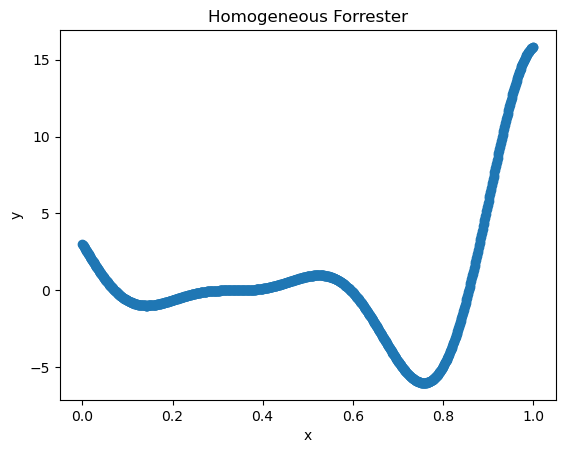

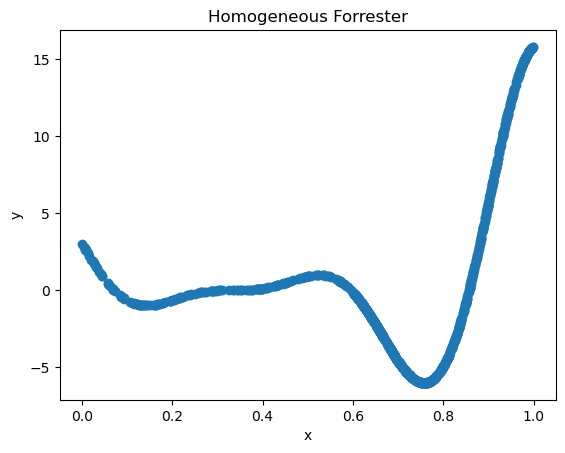

In [8]:
np_data, featureNames, targetNames = Forrester(heterogeneity = False)

plt.figure()
plt.scatter(np_data['x'],np_data['y'])
plt.title("Homogeneous Forrester")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

np_data, featureNames, targetNames = Forrester(heterogeneity = True)

plt.figure()
plt.scatter(np_data['x'],np_data['y'])
plt.title("Homogeneous Forrester")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

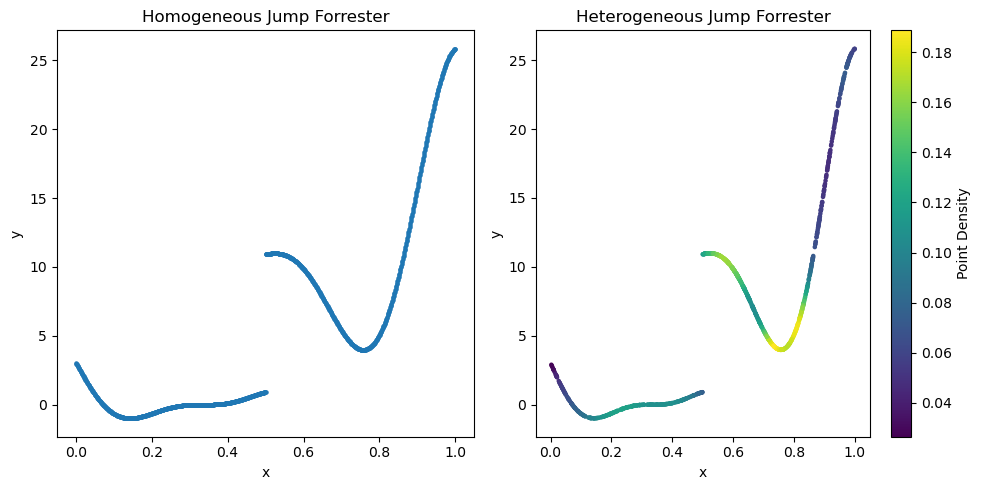

In [42]:
# # fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# # # First subplot (Homogeneous Forrester)
# # ax[0].scatter(np_data['x'], np_data['y'], s=1)  # s=10 makes the scatter dots smaller
# # ax[0].set_title("Homogeneous Forrester")
# # ax[0].set_xlabel('x')
# # ax[0].set_ylabel('y')

# # # Second subplot (Heterogeneous Forrester)
# # ax[1].scatter(np_data2['x'], np_data2['y'], s=1)  # s=10 makes the scatter dots smaller
# # ax[1].set_title("Heterogeneous Forrester")
# # ax[1].set_xlabel('x')
# # ax[1].set_ylabel('y')

# # # Adjust layout to avoid overlap
# # plt.tight_layout()

# # # Show the plot
# # plt.show()
# from scipy.stats import gaussian_kde
# x = np_data2['x']
# y = np_data2['y']

# # Calculate the point density
# xy = np.vstack([x, y])
# density = gaussian_kde(xy)(xy)

# # Create a figure with two subplots
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# # First subplot (Homogeneous Forrester)
# ax[0].scatter(np_data['x'], np_data['y'], s=5)  # s=10 makes scatter dots smaller
# ax[0].set_title("Homogeneous Jump Forrester")
# ax[0].set_xlabel('x')
# ax[0].set_ylabel('y')

# # Second subplot (Heterogeneous Forrester) with density highlighted
# sc = ax[1].scatter(x, y, c=density, s=5, cmap='viridis')  # Color based on density
# ax[1].set_title("Heterogeneous Jump Forrester")
# ax[1].set_xlabel('x')
# ax[1].set_ylabel('y')

# # Add colorbar to indicate density scale
# cbar = fig.colorbar(sc, ax=ax[1])
# cbar.set_label('Point Density')

# # Adjust layout to avoid overlap
# plt.tight_layout()

# # Show the plot
# plt.show()

In [76]:
# # Dataset Creation Jump Forrester
# np.random.seed(10)
# x1 = np.linspace(0, 0.5, 500)
# x2 = np.linspace(0.5, 1, 500)

# ###### Inbalanced
# # x1 = np.random.choice(np.linspace(0, 0.5, 10000), size=300, replace=False)
# # x2 = np.random.choice(np.linspace(0.5, 1, 10000), size=700, replace=False)


# x = np.concatenate((x1,x2))


# y1 = (6 * x1 - 2) ** 2 * np.sin(12 * x1 - 4)
# y2 = (6 * x2 - 2) ** 2 * np.sin(12 * x2 - 4) + 10
# y = np.concatenate((y1,y2))

# # Create unique names for each sample
# types = [f"Sample_{i+1}" for i in range(1000)]

# # Create a DataFrame with columns x, y, and type
# np_data = pd.DataFrame({'x': x, 'y': y, 'type': types})

# featureNames = ['x']
# targetNames = ['y']


In [5]:
# Dataset Creation Jump Forrester

def JumpForrester(heterogeneity = True):

    np.random.seed(10)

    if(heterogeneity):

        x1 = np.random.choice(np.linspace(0, 0.5, 10000), size=300, replace=False)
        x2 = np.random.choice(np.linspace(0.5, 1, 10000), size=700, replace=False)
    
    else:  

        x1 = np.linspace(0, 0.5, 500)
        x2 = np.linspace(0.5, 1, 500)

    
    x = np.concatenate((x1,x2))


    y1 = (6 * x1 - 2) ** 2 * np.sin(12 * x1 - 4)
    y2 = (6 * x2 - 2) ** 2 * np.sin(12 * x2 - 4) + 10
    y = np.concatenate((y1,y2))

    # Create unique names for each sample
    types = [f"Sample_{i+1}" for i in range(1000)]

    # Create a DataFrame with columns x, y, and type
    np_data = pd.DataFrame({'x': x, 'y': y, 'type': types})

    featureNames = ['x']
    targetNames = ['y']

    return np_data, featureNames, targetNames


In [26]:
# np.random.seed(10)

# # ALOS IS NOT USED
# # Dataset Creation ALOS D=2
# x1 = np.linspace(0, 1, 100)
# x2 = np.linspace(0, 1, 100)

# # Create all possible unique pairs using itertools.product
# all_pairs = np.array(list(itertools.product(x1, x2)))

# # Randomly select 2000 unique pairs
# selected_indices = np.random.choice(len(all_pairs), size=2000, replace=False)
# selected_pairs = all_pairs[selected_indices]

# # Define a function to calculate y
# def calculate_y(x1, x2):
#     return np.sin(21*(x1-0.9)**4) * np.cos(2*(x1-0.9)) + (x1-0.7)/2 + 2*(x2**2) * np.sin(x1)

# # Calculate y for each pair
# y = np.array([calculate_y(pair[0], pair[1]) for pair in selected_pairs])

# types = [f"Sample_{i+1}" for i in range(2000)]

# # Combine x1, x2, and y into a DataFrame
# np_data = pd.DataFrame(selected_pairs, columns=['x1', 'x2'])
# np_data['y'] = y
# np_data['type'] = types

# featureNames = ['x1','x2']
# targetNames = ['y']

In [35]:
# # Dataset Creation ALOS D=2
# np.random.seed(10)
# x1_1 = np.linspace(0, 0.2, 20)
# x1_2 = np.linspace(0.2, 0.4, 20)
# x1_3 = np.linspace(0.4, 1, 60)
# x2 = np.linspace(0, 1, 100)

# # Create all possible unique pairs using itertools.product
# all_pairs1 = np.array(list(itertools.product(x1_1, x2)))
# all_pairs2 = np.array(list(itertools.product(x1_2, x2)))
# all_pairs3 = np.array(list(itertools.product(x1_3, x2)))


# # Randomly select 2000 unique pairs
# selected_indices1 = np.random.choice(len(all_pairs1), size=300, replace=False)
# selected_pairs1 = all_pairs1[selected_indices1]

# selected_indices2 = np.random.choice(len(all_pairs2), size=700, replace=False)
# selected_pairs2 = all_pairs2[selected_indices2]

# selected_indices3 = np.random.choice(len(all_pairs3), size=1000, replace=False)
# selected_pairs3 = all_pairs3[selected_indices3]

# selected_pairs = np.concatenate((selected_pairs1,selected_pairs2,selected_pairs3))

# print(selected_pairs.shape)
# # Define a function to calculate y
# def calculate_y(x1, x2):
#     return np.sin(21*(x1-0.9)**4) * np.cos(2*(x1-0.9)) + (x1-0.7)/2 + 2*(x2**2) * np.sin(x1)

# # Calculate y for each pair
# y = np.array([calculate_y(pair[0], pair[1]) for pair in selected_pairs])

# types = [f"Sample_{i+1}" for i in range(2000)]

# # Combine x1, x2, and y into a DataFrame
# np_data = pd.DataFrame(selected_pairs, columns=['x1', 'x2'])
# np_data['y'] = y
# np_data['type'] = types

# featureNames = ['x1','x2']
# targetNames = ['y']


(2000, 2)


In [66]:
# # Dataset Gaussian
# np.random.seed(10)
# # Generate linspace for x1 and x2
# x1 = np.linspace(-3, 3, 100)
# x2 = np.linspace(-3, 3, 100)

# # Create all possible unique pairs using itertools.product
# all_pairs = np.array(list(itertools.product(x1, x2)))

# # Randomly select 2000 unique pairs
# selected_indices = np.random.choice(len(all_pairs), size=2000, replace=False)
# selected_pairs = all_pairs[selected_indices]

# # Define the 2D Gaussian function
# def gaussian_2d(x1, x2, sigma=1):
#     return np.exp(-(x1**2 + x2**2) / (2 * sigma**2))

# # Calculate y for each pair
# y = np.array([gaussian_2d(pair[0], pair[1]) for pair in selected_pairs])

# # Combine x1, x2, and y into a DataFrame
# np_data = pd.DataFrame(selected_pairs, columns=['x1', 'x2'])
# np_data['y'] = y

# types = [f"Sample_{i+1}" for i in range(2000)]
# np_data['type'] = types

# featureNames = ['x1','x2']
# targetNames = ['y']

In [6]:
# Define the 2D Gaussian function
def gaussian_2d(x1, x2, sigma=1):
    return np.exp(-(x1**2 + x2**2) / (2 * sigma**2))

# Dataset Gaussian

def Gaussian():
    np.random.seed(10)
    # Generate linspace for x1 and x2
    x1 = np.linspace(-3, 3, 100)
    x2 = np.linspace(-3, 3, 100)

    # Create all possible unique pairs using itertools.product
    all_pairs = np.array(list(itertools.product(x1, x2)))

    # Randomly select 2000 unique pairs
    selected_indices = np.random.choice(len(all_pairs), size=2000, replace=False)
    selected_pairs = all_pairs[selected_indices]

    # Calculate y for each pair
    y = np.array([gaussian_2d(pair[0], pair[1]) for pair in selected_pairs])

    # Combine x1, x2, and y into a DataFrame
    np_data = pd.DataFrame(selected_pairs, columns=['x1', 'x2'])
    np_data['y'] = y

    types = [f"Sample_{i+1}" for i in range(2000)]
    np_data['type'] = types

    featureNames = ['x1','x2']
    targetNames = ['y']
    
    return np_data, featureNames, targetNames

In [34]:
# # Inbalanced Gaussian
# np.random.seed(10)

# # Generate linspace for x1 and x2
# x1_1 = np.linspace(-0.5, 0.5, 100)
# x2_1 = np.linspace(-0.5, 0.5, 100)

# # Create all possible unique pairs using itertools.product
# all_pairs1 = np.array(list(itertools.product(x1_1, x2_1)))

# # Randomly select 2000 unique pairs
# selected_indices = np.random.choice(len(all_pairs1), size=500, replace=False)
# selected_pairs1 = all_pairs1[selected_indices]

# # Generate linspace for x1 and x2
# x1_2 = np.linspace(-3, 3, 100)
# x2_2 = np.linspace(-3, 3, 100)

# all_pairs = np.array(list(itertools.product(x1_2, x2_2)))

# outside_range_pairs = all_pairs[~((all_pairs[:, 0] >= -0.5) & (all_pairs[:, 0] <= 0.5) & 
#                                   (all_pairs[:, 1] >= -0.5) & (all_pairs[:, 1] <= 0.5))]


# selected_outside_indices = np.random.choice(len(outside_range_pairs), size=1500, replace=False)
# selected_outside_pairs = outside_range_pairs[selected_outside_indices]


# combined_pairs = np.vstack([selected_pairs1, selected_outside_pairs])

# # Define the 2D Gaussian function
# def gaussian_2d(x1, x2, sigma=1):
#     return np.exp(-(x1**2 + x2**2) / (2 * sigma**2))

# # Calculate y for each pair
# y = np.array([gaussian_2d(pair[0], pair[1]) for pair in combined_pairs])

# # Combine x1, x2, and y into a DataFrame
# np_data = pd.DataFrame(combined_pairs, columns=['x1', 'x2'])
# np_data['y'] = y

# # Assign sample types
# types = [f"Sample_{i+1}" for i in range(2000)]
# np_data['type'] = types

# featureNames = ['x1','x2']
# targetNames = ['y']

In [7]:
# Heterogeneous Gaussian

def Gaussian_heterogeneous():
    np.random.seed(10)

    # Generate linspace for x1 and x2
    x1_1 = np.linspace(-0.5, 0.5, 100)
    x2_1 = np.linspace(-0.5, 0.5, 100)

    # Create all possible unique pairs using itertools.product
    all_pairs1 = np.array(list(itertools.product(x1_1, x2_1)))

    # Randomly select 2000 unique pairs
    selected_indices = np.random.choice(len(all_pairs1), size=500, replace=False)
    selected_pairs1 = all_pairs1[selected_indices]

    # Generate linspace for x1 and x2
    x1_2 = np.linspace(-3, 3, 100)
    x2_2 = np.linspace(-3, 3, 100)

    # Create all possible unique pairs using itertools.product
    all_pairs = np.array(list(itertools.product(x1_2, x2_2)))

    # Find all pairs that do not belong in the central area
    outside_range_pairs = all_pairs[~((all_pairs[:, 0] >= -0.5) & (all_pairs[:, 0] <= 0.5) & 
                                    (all_pairs[:, 1] >= -0.5) & (all_pairs[:, 1] <= 0.5))]


    selected_outside_indices = np.random.choice(len(outside_range_pairs), size=1500, replace=False)
    selected_outside_pairs = outside_range_pairs[selected_outside_indices]


    combined_pairs = np.vstack([selected_pairs1, selected_outside_pairs])

    
    # Calculate y for each pair
    y = np.array([gaussian_2d(pair[0], pair[1]) for pair in combined_pairs])

    # Combine x1, x2, and y into a DataFrame
    np_data = pd.DataFrame(combined_pairs, columns=['x1', 'x2'])
    np_data['y'] = y

    # Assign sample types
    types = [f"Sample_{i+1}" for i in range(2000)]
    np_data['type'] = types

    featureNames = ['x1','x2']
    targetNames = ['y']

    return np_data, featureNames, targetNames


In [12]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# # First subplot (Homogeneous Gaussian) with color based on 'y' and plasma colormap
# sc1 = ax[0].scatter(np_data['x1'], np_data['x2'], c=np_data['y'], s=15, cmap='plasma')  # Plasma colormap
# ax[0].set_title("Homogeneous Gaussian")
# ax[0].set_xlabel('x1')
# ax[0].set_ylabel('x2')

# # Add colorbar for the first subplot
# cbar1 = fig.colorbar(sc1, ax=ax[0])
# cbar1.set_label('y')

# # Second subplot (Heterogeneous Gaussian) with color based on 'y' and cividis colormap
# sc2 = ax[1].scatter(np_data2['x1'], np_data2['x2'], c=np_data2['y'], s=15, cmap='plasma')  # Cividis colormap
# ax[1].set_title("Heterogeneous Gaussian")
# ax[1].set_xlabel('x1')
# ax[1].set_ylabel('x2')

# # Add colorbar for the second subplot
# cbar2 = fig.colorbar(sc2, ax=ax[1])
# cbar2.set_label('y')

# # Adjust layout to avoid overlap
# plt.tight_layout()

# # Show the plot
# plt.show()

In [9]:
plt.figure()

plt.scatter(np_data['x1'],np_data['x2'],c=np_data['y'])

plt.colorbar(label = 'y')
plt.title("Exponential 2D")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

NameError: name 'np_data' is not defined

<Figure size 640x480 with 0 Axes>

In [13]:
# # Gaussian with noise

# # Define the 2D Gaussian function
# def gaussian_2d(x1, x2,noise,sigma=1):
#     return np.exp(-(x1**2 + x2**2) / (2 * sigma**2)) + np.random.uniform(0, noise)

# # Inbalanced Gaussian + noise
# np.random.seed(10)

# # Generate linspace for x1 and x2
# x1_1 = np.linspace(-0.5, 0.5, 100)
# x2_1 = np.linspace(-0.5, 0.5, 100)

# # Create all possible unique pairs using itertools.product
# all_pairs1 = np.array(list(itertools.product(x1_1, x2_1)))

# # Randomly select 2000 unique pairs
# selected_indices = np.random.choice(len(all_pairs1), size=500, replace=False)
# selected_pairs1 = all_pairs1[selected_indices]

# y1 = np.array([gaussian_2d(pair[0], pair[1],0.5) for pair in selected_pairs1])

# # Generate linspace for x1 and x2
# x1_2 = np.linspace(-3, 3, 100)
# x2_2 = np.linspace(-3, 3, 100)

# all_pairs = np.array(list(itertools.product(x1_2, x2_2)))

# outside_range_pairs = all_pairs[~((all_pairs[:, 0] >= -0.5) & (all_pairs[:, 0] <= 0.5) & 
#                                   (all_pairs[:, 1] >= -0.5) & (all_pairs[:, 1] <= 0.5))]


# selected_outside_indices = np.random.choice(len(outside_range_pairs), size=1500, replace=False)
# selected_outside_pairs = outside_range_pairs[selected_outside_indices]

# y2 = np.array([gaussian_2d(pair[0], pair[1],0.2) for pair in selected_outside_pairs])

# combined_pairs = np.vstack([selected_pairs1, selected_outside_pairs])


# # Calculate y for each pair
# y = np.concatenate((y1,y2))

# # Combine x1, x2, and y into a DataFrame
# np_data = pd.DataFrame(combined_pairs, columns=['x1', 'x2'])
# np_data['y'] = y

# # Assign sample types
# types = [f"Sample_{i+1}" for i in range(2000)]
# np_data['type'] = types

# featureNames = ['x1','x2']
# targetNames = ['y']

In [8]:
# Define the 2D Gaussian function with noise
def gaussian_2d_noise(x1, x2,noise,sigma=1):
    return np.exp(-(x1**2 + x2**2) / (2 * sigma**2)) + np.random.uniform(0, noise)

def Gaussian_noise():
    # Heterogeneous Gaussian + noise
    np.random.seed(10)

    # Generate linspace for x1 and x2
    x1_1 = np.linspace(-0.5, 0.5, 100)
    x2_1 = np.linspace(-0.5, 0.5, 100)

    # Create all possible unique pairs using itertools.product
    all_pairs1 = np.array(list(itertools.product(x1_1, x2_1)))

    # Randomly select 2000 unique pairs
    selected_indices = np.random.choice(len(all_pairs1), size=500, replace=False)
    selected_pairs1 = all_pairs1[selected_indices]

    y1 = np.array([gaussian_2d(pair[0], pair[1],0.5) for pair in selected_pairs1])

    # Generate linspace for x1 and x2
    x1_2 = np.linspace(-3, 3, 100)
    x2_2 = np.linspace(-3, 3, 100)

    # Create all possible unique pairs using itertools.product
    all_pairs = np.array(list(itertools.product(x1_2, x2_2)))

    # Find all pairs that do not belong in the central area
    outside_range_pairs = all_pairs[~((all_pairs[:, 0] >= -0.5) & (all_pairs[:, 0] <= 0.5) & 
                                    (all_pairs[:, 1] >= -0.5) & (all_pairs[:, 1] <= 0.5))]


    selected_outside_indices = np.random.choice(len(outside_range_pairs), size=1500, replace=False)
    selected_outside_pairs = outside_range_pairs[selected_outside_indices]

    y2 = np.array([gaussian_2d_noise(pair[0], pair[1], 0.2) for pair in selected_outside_pairs])

    combined_pairs = np.vstack([selected_pairs1, selected_outside_pairs])


    # Calculate y for each pair
    y = np.concatenate((y1,y2))

    # Combine x1, x2, and y into a DataFrame
    np_data = pd.DataFrame(combined_pairs, columns=['x1', 'x2'])
    np_data['y'] = y

    # Assign sample types
    types = [f"Sample_{i+1}" for i in range(2000)]
    np_data['type'] = types

    featureNames = ['x1','x2']
    targetNames = ['y']

    return np_data, featureNames, targetNames

In [49]:
# np.random.seed(10)
# # Dataset Creation Exp D=2
# x1 = np.linspace(0, 1, 100)
# x2 = np.linspace(0, 1, 100)

# # Create all possible unique pairs using itertools.product
# all_pairs = np.array(list(itertools.product(x1, x2)))

# # Randomly select 2000 unique pairs
# selected_indices = np.random.choice(len(all_pairs), size=2000, replace=False)
# selected_pairs = all_pairs[selected_indices]

# # Define a function to calculate y
# def calculate_y(x1, x2):
#     return 1 - np.exp(-0.6 * ((x1 - 0.5)**2 + (x2 - 0.5)**2))

# # Calculate y for each pair
# y = np.array([calculate_y(pair[0], pair[1]) for pair in selected_pairs])

# types = [f"Sample_{i+1}" for i in range(2000)]

# # Combine x1, x2, and y into a DataFrame
# np_data = pd.DataFrame(selected_pairs, columns=['x1', 'x2'])
# np_data['y'] = y
# np_data['type'] = types

# featureNames = ['x1','x2']
# targetNames = ['y']

In [9]:
# Define a function to calculate y
def calculate_y_exp(x1, x2):
    return 1 - np.exp(-0.6 * ((x1 - 0.5)**2 + (x2 - 0.5)**2))

def Exponential():
    np.random.seed(10)
    x1 = np.linspace(0, 1, 100)
    x2 = np.linspace(0, 1, 100)

    # Create all possible unique pairs using itertools.product
    all_pairs = np.array(list(itertools.product(x1, x2)))

    # Randomly select 2000 unique pairs
    selected_indices = np.random.choice(len(all_pairs), size=2000, replace=False)
    selected_pairs = all_pairs[selected_indices]


    # Calculate y for each pair
    y = np.array([calculate_y_exp(pair[0], pair[1]) for pair in selected_pairs])

    types = [f"Sample_{i+1}" for i in range(2000)]

    # Combine x1, x2, and y into a DataFrame
    np_data = pd.DataFrame(selected_pairs, columns=['x1', 'x2'])
    np_data['y'] = y
    np_data['type'] = types

    featureNames = ['x1','x2']
    targetNames = ['y']

    return np_data, featureNames, targetNames

In [16]:
# # Exponential Imb
# np.random.seed(10)

# # Generate linspace for x1 and x2
# x1_1 = np.linspace(0.2, 0.8, 100)
# x2_1 = np.linspace(0.2, 0.8, 100)

# # Create all possible unique pairs using itertools.product
# all_pairs1 = np.array(list(itertools.product(x1_1, x2_1)))

# # Randomly select 2000 unique pairs
# selected_indices = np.random.choice(len(all_pairs1), size=500, replace=False)
# selected_pairs1 = all_pairs1[selected_indices]

# # Generate linspace for x1 and x2
# x1_2 = np.linspace(0, 1, 100)
# x2_2 = np.linspace(0, 1, 100)

# all_pairs = np.array(list(itertools.product(x1_2, x2_2)))

# outside_range_pairs = all_pairs[~((all_pairs[:, 0] >= 0.2) & (all_pairs[:, 0] <= 0.8) & 
#                                   (all_pairs[:, 1] >= 0.2) & (all_pairs[:, 1] <= 0.8))]


# selected_outside_indices = np.random.choice(len(outside_range_pairs), size=1500, replace=False)
# selected_outside_pairs = outside_range_pairs[selected_outside_indices]


# combined_pairs = np.vstack([selected_pairs1, selected_outside_pairs])

# # Define a function to calculate y
# def calculate_y(x1, x2):
#     return 1 - np.exp(-0.6 * ((x1 - 0.5)**2 + (x2 - 0.5)**2))

# # Calculate y for each pair
# y = np.array([calculate_y(pair[0], pair[1]) for pair in combined_pairs])

# # Combine x1, x2, and y into a DataFrame
# np_data = pd.DataFrame(combined_pairs, columns=['x1', 'x2'])
# np_data['y'] = y

# # Assign sample types
# types = [f"Sample_{i+1}" for i in range(2000)]
# np_data['type'] = types

# featureNames = ['x1','x2']
# targetNames = ['y']

In [28]:
def Exponential_heterogeneous():
    
    np.random.seed(10)

    # Generate linspace for x1 and x2
    x1_1 = np.linspace(0.2, 0.8, 100)
    x2_1 = np.linspace(0.2, 0.8, 100)

    # Create all possible unique pairs using itertools.product
    all_pairs1 = np.array(list(itertools.product(x1_1, x2_1)))

    # Randomly select 2000 unique pairs
    selected_indices = np.random.choice(len(all_pairs1), size=500, replace=False)
    selected_pairs1 = all_pairs1[selected_indices]

    # Generate linspace for x1 and x2
    x1_2 = np.linspace(0, 1, 100)
    x2_2 = np.linspace(0, 1, 100)

    all_pairs = np.array(list(itertools.product(x1_2, x2_2)))

    outside_range_pairs = all_pairs[~((all_pairs[:, 0] >= 0.2) & (all_pairs[:, 0] <= 0.8) & 
                                    (all_pairs[:, 1] >= 0.2) & (all_pairs[:, 1] <= 0.8))]


    selected_outside_indices = np.random.choice(len(outside_range_pairs), size=1500, replace=False)
    selected_outside_pairs = outside_range_pairs[selected_outside_indices]


    combined_pairs = np.vstack([selected_pairs1, selected_outside_pairs])


    # Calculate y for each pair
    y = np.array([calculate_y_exp(pair[0], pair[1]) for pair in combined_pairs])

    # Combine x1, x2, and y into a DataFrame
    np_data = pd.DataFrame(combined_pairs, columns=['x1', 'x2'])
    np_data['y'] = y

    # Assign sample types
    types = [f"Sample_{i+1}" for i in range(2000)]
    np_data['type'] = types

    featureNames = ['x1','x2']
    targetNames = ['y']
    
    return np_data, featureNames, targetNames

In [11]:
#np_data, featureNames, targetNames = data_preparation("../train_data/train_zifs_diffusivity/TrainData.xlsx")
#np_data, featureNames, targetNames = data_preparation("../train_data/MOFsMMM/Methane.csv",research_data = "ch4")
#np_data, featureNames, targetNames = data_preparation("../train_data/properties.csv",research_data = "methane")
#np_data, featureNames, targetNames = data_preparation("../train_data/MOFdata.csv",research_data = "o2")
#np_data, featureNames, targetNames = data_preparation("../train_data/MOFsMMM/Hydrogen.csv",research_data = "h2")
#np_data, featureNames, targetNames = data_preparation("../train_data/MOFsMMM/Helium.csv",research_data = "he")
#np_data, featureNames, targetNames = data_preparation("../train_data/alpha_ads_data_and_CO2_WC_data.csv",research_data = "co2/n2")

# Forrester Balanced
np_data, featureNames, targetNames = Forrester(heterogeneity = False)


# Instantiate the XGB regressor model
XGBR = XGBRegressor(n_estimators=500, max_depth=5, eta=0.07, subsample=0.75, colsample_bytree=0.7, reg_lambda=0.4, reg_alpha=0.13,
                        random_state=6410 ) #,device = "cuda"

#gp_model = GaussianProcessRegressor(kernel=RationalQuadratic(length_scale=1.0, alpha=1.5))

In [7]:
# No need to run
# Initial Query Selection Indexes
for i in range(10):

    #start_indexes = np.random.choice(np.arange(0,100),size=5,replace=False)
    print(np.load(f'./Init_Index/start_{i}.npy'))

[55 40  0 83 58]
[97 56 62 20 70]
[58 30  0 37 94]
[95 65 20 72 84]
[19 15 51 75 93]
[48 49 75 82 45]
[68 27 98 45 28]
[66 60 31 34 80]
[78 64 84 99 88]
[96 58  1 37 93]


In [6]:
# # Not used
# ### Bootstraping for estimating confidence 
# def train_ensemble(X, y, n_models=10):
#     models = []
#     for i in range(n_models):
#         # Bootstrap sampling
#         X_sample, y_sample = resample(X, y)
#         model = XGBRegressor(n_estimators=500, max_depth=5, eta=0.07, subsample=0.75, colsample_bytree=0.7, reg_lambda=0.4, reg_alpha=0.13,
#                         random_state=(6410))
#         model.fit(X_sample, y_sample.ravel())
#         models.append(model)
#     return models

# def predict_with_ensemble(models, X):
#     predictions = np.array([model.predict(X) for model in models])
#     mean_prediction = np.mean(predictions, axis=0)
#     std_prediction = np.std(predictions, axis=0)
#     return mean_prediction, std_prediction

# def uncertainty_sampling(models, X_unlabeled,fefeatureNames):
#     x_unlabeled = X_unlabeled[featureNames].to_numpy()
#     _, std_prediction = predict_with_ensemble(models, x_unlabeled)
#     # Select the top k most uncertain samples
#     #uncertain_indices = std_prediction.argsort()[-k:]
#     return std_prediction #uncertain_indices

In [12]:
### GP uncertainty
def Gp_uncertainty(X_train,y_train,X_unlabeled,featureNames):
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    # Define GP surrogate
    gp_model = GaussianProcessRegressor(kernel=RationalQuadratic(length_scale=1.0, alpha=1.5))  #RationalQuadratic(length_scale=1.0, alpha=1.5)
    gp_model.fit(X_train,y_train.ravel())
    y_pred, y_std = gp_model.predict(x_unlabeled,return_std=True)

    #y_std_mean = np.mean(y_std)
    #y_std  = np.abs(y_std - y_std_mean)
    uncertainties = y_std #.argsort()[-1:]
    return uncertainties

In [13]:
# Possibly not used

def Greedy_AL(model,X_train,y_train,X_unlabeled,featureNames,targetNames):
   x_unlabeled = X_unlabeled[featureNames].to_numpy()  
   y_pred = model.predict(x_unlabeled)
   
   y_true = X_unlabeled[targetNames].to_numpy()
   #metrics.mean_absolute_error(y_true,y_pred)
   mae_error = np.abs(y_true.reshape(-1) - y_pred)

   # dist = []
   # for y_ul in y_pred:
   #    dist_ul = np.sqrt((y_ul-y_train)**2)
      
   #    dist_ul = np.sort(dist_ul)
   #    dist.append(dist_ul[0])
   #print("min mae is",np.min(mae_error))
   #bool_mae = mae_error < 0.01
   #print("count is",sum(bool_mae))
   return mae_error      

In [14]:
def qbc(model,X_train,y_train,X_unlabeled,featureNames,targetNames):
    
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    gp_model = GaussianProcessRegressor(kernel=RationalQuadratic(length_scale=1.0, alpha=1.5))  #RationalQuadratic(length_scale=1.0, alpha=1.5)
    gp_model.fit(X_train,y_train.ravel())
    y_pred1, y_std = gp_model.predict(x_unlabeled,return_std=True)

    y_pred2 = model.predict(x_unlabeled)

    regr = RandomForestRegressor(max_depth=5, random_state=0)
    regr.fit(X_train,y_train.ravel())

    y_pred3 = regr.predict(x_unlabeled)

    # d1 = np.sqrt((y_pred1-y_pred2)**2)
    # d2 = np.sqrt((y_pred1-y_pred3)**2)
    # d4 = np.sqrt((y_pred2-y_pred3)**2) 
    
    # res = (d1 + d2 + d4 )/3

    stacked_ypreds = np.column_stack((y_pred1, y_pred2, y_pred3))
    
    # Calculate the standard deviation along the first axis (row-wise)

    #  Query the point with maximum variance max uncertainty
    res = np.var(stacked_ypreds, axis=1)

    index = np.argmax(res)
     
    return index,res 


In [112]:
# # Use the other qbc
# def qbc2(model,X_train,y_train,X_unlabeled,featureNames,targetNames):
#     x_unlabeled = X_unlabeled[featureNames].to_numpy()
#     gp_model = GaussianProcessRegressor(kernel=RationalQuadratic(length_scale=1.0, alpha=1.5))  #RationalQuadratic(length_scale=1.0, alpha=1.5)
#     gp_model.fit(X_train,y_train.ravel())
#     y_pred1, y_std = gp_model.predict(x_unlabeled,return_std=True)

#     y_pred2 = model.predict(x_unlabeled)

#     regr = RandomForestRegressor(max_depth=5, random_state=0)
#     regr.fit(X_train,y_train.ravel())

#     y_pred3 = regr.predict(x_unlabeled)

#     d1 = np.sqrt((y_pred1-y_pred2)**2)
#     d2 = np.sqrt((y_pred1-y_pred3)**2)
#     d3 = np.sqrt((y_pred2-y_pred3)**2) 
     
#     res = (d1 + d2 + d3)/3
#     # stacked_ypreds = np.vstack((y_pred1, y_pred2, y_pred3))

#     # # Calculate the standard deviation along the first axis (row-wise)
#     # res = np.std(stacked_ypreds, axis=0)
    
  
#     return res 

In [15]:
def select_max_y(model,X_unlabeled,featureNames):
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    y_pred = model.predict(x_unlabeled)
    return y_pred

In [12]:
# # Possibly ont used (Chistoforos' method)
# def predictor (train_x, train_y, test_x, featureNames ,model):
                    
#     #Training
#     train_y_model=model.fit(train_x,train_y.ravel())

#     #predict_y=model.predict(X)
    
#     # #Uncertainty prediction on test data set
#     # predict_y_errror=model.predict(test_x)
#     # predict_y4Sub=np.reshape(predict_y_errror, (test_x.shape[0],1))
#     # uncertainty_test=np.absolute(np.subtract(predict_y4Sub, test_y))

#     ##Uncertainty train estimation
#     train_y_uns=model.predict(train_x)
#     #train_y_uns4sub=np.reshape(train_y_uns, (train_x.shape[0],1))
#     uncertainty_train=np.absolute(train_y_uns-train_y.ravel())
#     uncertainty_train_norm=np.absolute((uncertainty_train/train_y.ravel()))

#     return uncertainty_train #predict_y, , uncertainty_test


# def uncertainty_predictor (train_x, train_y, test_x, featureNames,model):
    
#     #define cross-validation method to use
#     #cv = LeaveOneOut()

#     #use LOOCV to evaluate model
#     #train_y_CV = cross_val_predict(model, train_x, train_y.ravel(), cv=cv)

#     train_y_model=model.fit(train_x,train_y)

#     test_X = test_x[featureNames].to_numpy()
#     predict_unc=np.absolute(model.predict(test_X))

#     return predict_unc


In [16]:
def find_nearest_sample(model,X_train,y_train,X_unlabeled,featureNames):
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    
    # Compute the pairwise Euclidean distances between each unlabeled sample and all training samples
    distances = cdist(x_unlabeled, X_train, metric='euclidean')
    
    # Find the minimum distance and the corresponding index
    min_distances = np.min(distances, axis=1)
    nearest_sample_index = np.argmin(min_distances)
    
    # Return the nearest unlabeled sample, the corresponding distance, and index
    nearest_sample = X_unlabeled.iloc[nearest_sample_index]
    nearest_distance = min_distances[nearest_sample_index]
    return  nearest_sample_index, min_distances #nearest_sample #, nearest_distance, nearest_sample_index

In [17]:
def Gsx(model,X_train,y_train,X_unlabeled,featureNames):
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    
    # Compute the pairwise Euclidean distances between each unlabeled sample and all training samples
    distances = cdist(x_unlabeled, X_train, metric='euclidean')
    
    # Find the minimum distance and the corresponding index
    min_distances = np.min(distances, axis=1)
    result_index = np.argmax(min_distances)
    
    return  result_index,min_distances #nearest_sample #, nearest_distance, nearest_sample_index

In [18]:
def Gsy(model,X_train,y_train,X_unlabeled,featureNames):
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    
    y_pred = model.predict(x_unlabeled)
   
    y_train = y_train.ravel()

    min_distances = []

    for pred in y_pred:
        
        distances = np.sqrt((y_train - pred) ** 2)

        min_distances.append(np.min(distances))
    
    
    min_distances = np.array(min_distances)
    
    result_index = np.argmax(min_distances)
    
    return  result_index, min_distances #nearest_sample #, nearest_distance, nearest_sample_index

In [19]:
# This one is used in the plots (igs variant).
def iGS(model,x_train,y_train,x_unlabeled,featureNames):
    res_x,dist_x = Gsx(model,x_train,y_train,x_unlabeled,featureNames)
    res_y,dist_y = Gsy(model,x_train,y_train,x_unlabeled,featureNames)

    dist = dist_x * dist_y
    result_index = np.argmax(dist)
    return result_index, dist

In [9]:
# def iGS2(model,x_train,y_train,X_unlabeled,featureNames):
    
#     x_unlabeled = X_unlabeled[featureNames].to_numpy()

#     # Compute the pairwise Euclidean distances between each unlabeled sample and all training samples
#     distances_x = cdist(x_unlabeled, x_train, metric='euclidean')

#     y_pred = model.predict(x_unlabeled)
   
#     y_train = y_train.ravel()

#     distances_y = []

#     for pred in y_pred:
        
#         distances = np.sqrt((y_train - pred) ** 2)

#         distances_y.append(distances)
    
    
#     distances = distances_x * distances_y
#     #print(distances.shape)

#     min_distances = np.min(distances, axis=1)
#     #print(min_distances.shape)
#     result_index = np.argmax(min_distances)
#     return result_index, min_distances


In [20]:
def density_unc(model,x_train,y_train,X_unlabeled,featureNames):
    
    x_unlabeled = X_unlabeled[featureNames].to_numpy()

    # scaler = StandardScaler()
    # x_unlabeled = scaler.fit_transform(x_unlabeled)

    nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(x_unlabeled)
    distances, indices = nbrs.kneighbors(x_unlabeled)
    density = 1 / distances.mean(axis=1)

    # Run the iGS method to produce uncertainties 
    index, uncertainty = iGS(model,x_train,y_train,X_unlabeled,featureNames) #Gp_uncertainty(x_train,y_train,X_unlabeled,featureNames)

    # Run the iGS2 method to produce uncertainties 
    # index, uncertainty = iGS2(model,x_train,y_train,X_unlabeled,featureNames) #Gp_uncertainty(x_train,y_train,X_unlabeled,featureNames)
    
    result_index = np.argmax(uncertainty * density)
    # print("Selected sample density",density[result_index])
    # print("iGS sample density",density[index])
    # print()

    return result_index
    

In [10]:
# # Not used
# def Active_strategy(model,x_train,y_train,x_unlabeled,featureNames,targetNames,explore):
    
#     uncertainties = qbc2(model,x_train, y_train,x_unlabeled,featureNames,targetNames) #, low_unc_mae
                    
#     if(explore == 2 or explore == 3 or explore == 4):
#         uncertainties_mean = np.mean(uncertainties)
#         uncertainties = np.abs(uncertainties-uncertainties_mean)
#         index = np.random.randint(len(uncertainties))
        
    
#     elif(explore == 5):
#         index = np.argmax(uncertainties)  
        
#     else:
        
#         uncertainties_mean = np.mean(uncertainties)
#         uncertainties = np.abs(uncertainties-uncertainties_mean) 
#         index = np.argmin(uncertainties)   
    
#     return index

In [21]:
class OptimizationFactory(ABC):
    def optimizeModel():
        pass

class ActiveLearning(OptimizationFactory):

    # def __init__(self):
    #     self.logPrefix = "Active Learning"

    def optimizeModel(self, model : any, zifs : pd.DataFrame, X_featureNames : list, Y_featureNames : list , designspace_thres : int, seedno : int, exp_num : int, method : str) -> pd.DataFrame:
        

        np.random.seed(seedno)
        optimization_start_time = time.time()

    
        # Initialize dictionary of errors per training data size
        uniqueZIFs = zifs.type.unique()
        fold_num = 10
        
        select_data_points_num = designspace_thres

        # print(design_space)
        # print(fold_design_space)
        # print(select_data_points_num)

        zif_kfold = KFold(n_splits=fold_num, shuffle=True, random_state=seedno)
        inner_round = 0 
        
        maePerTrainSize = {}
        bestPerformingData          = {}
        names = []
        target = []
        i = 0
        for train_zif_indicies, left_out_zif_indicies in zif_kfold.split(uniqueZIFs):
            np.random.seed(seedno)
            inner_round += 1
            #roundPath = os.path.join(save_path, "Round_" + str(inner_round))
            #os.mkdir(roundPath)
            # print(train_zif_indicies.shape)
            # print(left_out_zif_indicies)
            roundMae = []

            trainZIFnames = np.delete(uniqueZIFs, left_out_zif_indicies)
            testZIFname   = uniqueZIFs[left_out_zif_indicies]

            trainZIFs = zifs[~zifs['type'].isin(testZIFname)]
            testZIFs  = zifs[zifs['type'].isin(testZIFname)]
    
            
            selectRandomSample = 0
            currentData   = pd.DataFrame()

            maeBestPerformanceList      = []
            maeStopCriterionMet         = False
            random_flag  = False
            active_counter = 0
            explore = 0
            wait_ep =0
            c = 0
            # if(i==0):
            #     i+=1
            #     continue
            
            init_indexes = np.load(f'./Init_Index/start_{exp_num}.npy')

            for random_index in init_indexes:
                randomZifName = trainZIFs.iloc[random_index]["type"]
                selectedZIF  = trainZIFs[(trainZIFs['type'] == randomZifName)]
                        
                names.append(randomZifName)
                target.append(selectedZIF[Y_featureNames])
                
                trainZIFs     = trainZIFs[(trainZIFs['type']) != randomZifName]
                trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == randomZifName))
                currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)

            x_trainAll = currentData[X_featureNames].to_numpy()
            y_trainAll = currentData[Y_featureNames].to_numpy()  

            model.fit(x_trainAll, y_trainAll.ravel())  

            for sizeOfTrainZIFs in range(select_data_points_num-5):

                if random_flag:
                    
                    randomSelection = RandomSelectionStrategy()
                    randomZifName = randomSelection.select_next_instance(trainZIFnames)
                    selectedZIF  = trainZIFs[(trainZIFs['type'] == randomZifName)]
                    #print(randomZifName)
                    names.append(randomZifName)
                    target.append(selectedZIF[Y_featureNames])

                    # Remove the sellected ZIF from the list of available for training
                    trainZIFs     = trainZIFs[(trainZIFs['type']) != randomZifName]
                    trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == randomZifName))
                    currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)
                    random_flag  = False
                 

                else:
                    # select_index = density_unc(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames)
                    #select_index, dist= iGS2(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames)
                    #select_index, dist = qbc(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames,Y_featureNames)
                    
                    select_inde = None
                    dist = None
                    if method == "density":
                        select_index = density_unc(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames)
                    elif method == "igs":
                        select_index, dist= iGS(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames)
                    elif method == "qbc":
                        select_index, dist = qbc(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames,Y_featureNames)
                    else:
                        print("Error method not recognised.")
                        exit()
                    
                    selected_name = trainZIFs.iloc[select_index]["type"]
                    
                    # Not needed
                    #model_ensemble = train_ensemble(x_trainAll, y_trainAll, n_models=15)
                    #uncertainties = uncertainty_sampling(model_ensemble,trainZIFs,X_featureNames)
                    
                    # Select most uncertain data point
                    # uncertainties = Gp_uncertainty(x_trainAll, y_trainAll,trainZIFs,X_featureNames)
                    
                    #uncertainties = qbc(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames,Y_featureNames) #, low_unc_mae
                    #print(np.min(uncertainties))
                    
                    # uncertainty_train = predictor(x_trainAll, y_trainAll, trainZIFs,X_featureNames, model)
                    # uncertainties = uncertainty_predictor(x_trainAll, uncertainty_train, trainZIFs, featureNames, model)
                    # if(explore == 2 or explore == 3 or explore == 4):
                    #     uncertainties_mean = np.mean(uncertainties)
                    #     uncertainties = np.abs(uncertainties-uncertainties_mean)
                    #     random_index = np.random.randint(len(uncertainties))
                    #     selected_name = trainZIFs.iloc[random_index]["type"]
                    #     explore +=1
                    #     # if(explore==4):
                    #     #     explore = 0 

                
                    
                    # elif(explore == 5):
                    #     selected_name = trainZIFs.iloc[np.argmax(uncertainties)]["type"] 
                    #     explore = 0  
                        
                    # else:
                        
                    #     uncertainties_mean = np.mean(uncertainties)
                    #     uncertainties = np.abs(uncertainties-uncertainties_mean)    
                    #     selected_name = trainZIFs.iloc[np.argmin(uncertainties)]["type"]
                    #     explore+=1
                    
                    # x = trainZIFs[X_featureNames].to_numpy()
                    # if(sizeOfTrainZIFs<50):
                    #     if c<8:
                    #         indices = np.where((x > 0.6) & (x < 0.9))[0]
                    #         random_index = np.random.choice(indices, replace=False)
                    #         selected_name = trainZIFs.iloc[random_index]["type"]
                    #         c+=1

                    #     else:
                    #         indices = np.where((x <= 0.6) | (x >= 0.9))[0]
                    #         random_index = np.random.choice(indices, replace=False)
                    #         selected_name = trainZIFs.iloc[random_index]["type"]
                    #         c+=1
                    # else:
                    #     if c<6:
                    #         indices = np.where((x > 0.6) & (x < 0.9))[0]
                    #         random_index = np.random.choice(indices, replace=False)
                    #         selected_name = trainZIFs.iloc[random_index]["type"]
                    #         c+=1

                    #     else:
                    #         indices = np.where((x <= 0.6) | (x >= 0.9))[0]
                    #         random_index = np.random.choice(indices, replace=False)
                    #         selected_name = trainZIFs.iloc[random_index]["type"]
                    #         c+=1        
                        
                    # if(c==10):
                    #     c=0

                    # uncertainty_train = predictor(x_trainAll, y_trainAll, trainZIFs,X_featureNames, model)
                    # uncertainties = uncertainty_predictor(x_trainAll, uncertainty_train, trainZIFs, featureNames, model)
                    # selected_name = trainZIFs.iloc[np.argmax(uncertainties)]["type"]
                    #selected_name = trainZIFs.iloc[np.argmax(uncertainties)]["type"]
                    names.append(selected_name)
                    selectedZIF = trainZIFs[(trainZIFs['type'] == selected_name)]
                    target.append(selectedZIF[Y_featureNames])
                    # Remove the sellected ZIF from the list of available for training
                    trainZIFs = trainZIFs[(trainZIFs['type']) != selected_name]
                    trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == selected_name))
                    
                    currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)

                    # unc_names = []
                    # c = 0
                    # wait_ep +=1
                    # if(wait_ep>20):
                        
                    #     # FIX remove selected i from low unc mae
                    #     for i in range(len(low_unc_mae)):
                    #         if(low_unc_mae[i] and c<10 and i<len(low_unc_mae)-1):
                                
                    #             low_unc_name = trainZIFs.iloc[i]["type"]
                    #             if(low_unc_name!=selected_name):
                    #                 selectedZIF_unc = trainZIFs[(trainZIFs['type'] == low_unc_name)]
                                    
                    #                 # min_index = find_nearest_sample(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames)
                    #                 # min_name = trainZIFs.iloc[min_index]["type"]
                    #                 # selectedZIF_unc = trainZIFs[(trainZIFs['type'] == min_name)]

                    #                 selectzif = selectedZIF_unc[X_featureNames].to_numpy()
                                   
                    #                 y_pred = model.predict(selectzif)
                    #                 # print(metrics.mean_absolute_error(selectedZIF_unc[Y_featureNames],y_pred))
                    #                 selectedZIF_unc[Y_featureNames] = y_pred
                                    

                    #                 unc_names.append(low_unc_name)
                    #                 currentData = pd.concat([currentData, selectedZIF_unc], axis=0, ignore_index=True)
                    #                 c+=1

                    #     for unc_name in unc_names:
                    #         trainZIFs = trainZIFs[(trainZIFs['type']) != unc_name]
                    #         trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == unc_name))

                    # # #####  Min dist loop     
                    # unc_names = []
                    # c = 0
                    # wait_ep +=1
                    # if(wait_ep>80):
                        
                    #     x_trainAll = currentData[X_featureNames].to_numpy()
                    #     y_trainAll = currentData[Y_featureNames].to_numpy()
                    #     # FIX remove selected i from low unc mae
                    #     for i in range(5):
                    #         #dist = Greedy_AL(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames,Y_featureNames)
                    #         #uncertainties, low_unc_mae = qbc(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames,Y_featureNames,sizeOfTrainZIFs)
                    #         #min_index = np.argmin(dist)
                    #         min_index, dist = find_nearest_sample(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames)
                            
                    #         # pca = PCA(n_components=2)
                    #         # x = trainZIFs[X_featureNames].to_numpy()
                    #         # y = trainZIFs[Y_featureNames].to_numpy()

                    #         # scaler = StandardScaler()
                    #         # x = scaler.fit_transform(x)
                    #         # X_pca = pca.fit_transform(x)
                    #         # # Filter based on conditions
                    #         # filtered_indices = np.where((X_pca[:, 0] > 0) & (X_pca[:, 1] < 0))[0]

                    #         # # dist2 = dist[filtered_indices]
                    #         # # min_dist_ind = np.argmin(dist2)
                    #         # # min_index = filtered_indices[min_dist_ind] 
                    #         # min_index = np.random.choice(filtered_indices)
                            
                    #         min_name = trainZIFs.iloc[min_index]["type"]
                    #         if(min_name!=selected_name):
                    #             selectedZIF_unc = trainZIFs[(trainZIFs['type'] == min_name)]

                    #             selectzif = selectedZIF_unc[X_featureNames].to_numpy()
                                    
                    #             y_pred = model.predict(selectzif)
                    #             #print(metrics.mean_absolute_error(selectedZIF_unc[Y_featureNames],y_pred))
                    #             #print(uncertainties[min_index])
                    #             selectedZIF_unc[Y_featureNames] = y_pred #.reshape(1,1)
                    #             currentData = pd.concat([currentData, selectedZIF_unc], axis=0, ignore_index=True)
                                

                    #             # x = trainZIFs[X_featureNames].to_numpy()
                    #             # pca = PCA(n_components=2)
                    #             # x_trainAll_pca = pca.fit_transform(x_trainAll)  # Fit and transform x_trainAll
                    #             # x_pca = pca.transform(x)  # Transform x into the same PCA space as x_trainAll
                    #             # distances = cdist(x_pca, x_trainAll_pca, metric='euclidean')
                    #             # min_distances = np.mean(distances, axis=1)  # Average distance for each sample in x
                    #             # nearest_sample_index = np.argmin(min_distances)  # Index of the nearest sample in x
                            
                    #             # pca_name = trainZIFs.iloc[nearest_sample_index]["type"]
                                    
                    #             # selectedZIF_pca = trainZIFs[(trainZIFs['type'] == pca_name)]
                    #             # selectzif_pca = selectedZIF_pca[X_featureNames].to_numpy()
                    #             # y_pred = model.predict(selectzif_pca)
                    #             # print(metrics.mean_absolute_error(selectedZIF_pca[Y_featureNames],y_pred))
                                
                                
                    #             # PCA transform
                    #             # pca = PCA(n_components=2)
                    #             # x = trainZIFs[X_featureNames].to_numpy()
                    #             # y = trainZIFs[Y_featureNames].to_numpy()

                    #             # scaler = StandardScaler()
                    #             # x = scaler.fit_transform(x)
                    #             # X_pca = pca.fit_transform(x)

                                
                    #             # # Calculate MAE for each sample
                    #             # y_true = trainZIFs[Y_featureNames].to_numpy().reshape(-1)
                               
                    #             # y_pred_all = model.predict(trainZIFs[X_featureNames])
                                
                    #             # train_mae = np.abs(y_true - y_pred_all)  # Flatten to get per-sample MAE
                                
                    #             # # Perform heatmap analysis
                    #             # # Create a 2D histogram (heatmap) of the PCA components
                    #             # #heatmap_data, xedges, yedges = np.histogram2d(X_pca[:, 0], X_pca[:, 1], bins=50, weights=train_mae)

                    #             # # Plot the heatmap
                    #             # #plt.imshow(heatmap_data.T, origin='lower', aspect='auto', cmap='viridis') #, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]
                    #             # scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_mae, cmap='viridis', s=50)
                    #             # plt.colorbar(scatter, label='Mean Absolute Error')
                    #             # plt.xlabel('PCA Component 1')
                    #             # plt.ylabel('PCA Component 2')
                    #             # plt.title('Heatmap of MAE on PCA-Transformed Features') 

                    #             # selected_sample_pca = X_pca[min_index]

                    #             # # Plot the selected sample on the heatmap
                    #             # plt.scatter(selected_sample_pca[0], selected_sample_pca[1], color='red', marker='o', label='Selected Sample')
                    #             # plt.legend()
                    #             # plt.show()       

                    #             # # For uncertainties
                    #             # scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dist, cmap='viridis', s=50)
                    #             # plt.colorbar(scatter, label='uncertainties')
                    #             # plt.xlabel('PCA Component 1')
                    #             # plt.ylabel('PCA Component 2')
                    #             # plt.title('Heatmap of unc on PCA-Transformed Features') 

                    #             # selected_sample_pca = X_pca[min_index]

                    #             # # Plot the selected sample on the heatmap
                    #             # plt.scatter(selected_sample_pca[0], selected_sample_pca[1], color='red', marker='o', label='Selected Sample')
                    #             # plt.legend()
                    #             # plt.show()

                    #             # Remove from unlabeled set 
                    #             trainZIFs = trainZIFs[(trainZIFs['type']) != min_name]
                    #             trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == min_name))
                                

                        
                    # active_counter += 1
                    # if(active_counter==10):
                    #     random_flag  = True
                    #     active_counter = 0

                # Add the next ZIF to the currently used data.
                #currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)

                
                # Create feature matrices for all currently used data.
                x_trainAll = currentData[X_featureNames].to_numpy()
                y_trainAll = currentData[Y_featureNames].to_numpy()

                currentBatchNames = currentData.type.unique()
                trainLength = len(currentBatchNames)
                #print("TrainLength is",len(currentBatchNames))
                if (sizeOfTrainZIFs + 1) not in bestPerformingData.keys():
                        bestPerformingData[(sizeOfTrainZIFs + 1)] = []
                
                # Append mae to the corresponding dictionary list
                bestPerformingData[(sizeOfTrainZIFs + 1)].append(selectedZIF)

                if(trainLength>=5):
                    
                    #print(np.min(uncertainties))
                    
                    
                    # Train XGboost with the updated dataset 
                    model.fit(x_trainAll, y_trainAll.ravel())
                    
                    # Prediction on outer leave one out test data
                    x_test  = testZIFs[X_featureNames].to_numpy()
                    y_test  = testZIFs[Y_featureNames].to_numpy()
                    
                    y_pred = model.predict(x_test)
                    y_pred_train = model.predict(x_trainAll)
                    mae_train = metrics.mean_absolute_error(y_trainAll,y_pred_train)
                    
                    mae = metrics.mean_absolute_error(y_test, y_pred)
                    
                    print("Round",inner_round,"train size",sizeOfTrainZIFs+1,"mae is",mae,"train_mae is",mae_train)
  

                    if (sizeOfTrainZIFs + 1) not in maePerTrainSize.keys():
                        maePerTrainSize[(sizeOfTrainZIFs + 1)] = []

                          
                    # Append mae to the corresponding dictionary list
                    maePerTrainSize[(sizeOfTrainZIFs + 1)].append(mae)
            #break
            
        
        print(maePerTrainSize.keys())    
        result_df = pd.DataFrame()
        result_df["sizeOfTrainingSet"]       = np.array([iCnt for iCnt in sorted(maePerTrainSize.keys()) ])
        result_df["averageError"]            = [ np.array(maePerTrainSize[iCnt]).mean() for iCnt in maePerTrainSize.keys() ]
        result_df["stdErrorOfMeanError"]     = [ np.array(maePerTrainSize[iCnt]).std() / math.sqrt(iCnt) for iCnt in maePerTrainSize.keys() ]
        result_df["stdDeviationOfMeanError"] = [ np.array(maePerTrainSize[iCnt]).std()  for iCnt in maePerTrainSize.keys() ]
        return result_df,names,target#bestPerformingData



In [22]:
class RandomSampling(OptimizationFactory):

    # def __init__(self):
    #     self.logPrefix = "Active Learning"

    def optimizeModel(self, model : any, zifs : pd.DataFrame, X_featureNames : list, Y_featureNames : list , designspace_thres : int, seedno : int, exp_num : int) -> pd.DataFrame:
        

        np.random.seed(seedno)
        optimization_start_time = time.time()

        # Make a list with all unique ZIF names.
        uniqueZIFs = zifs.type.unique()

        # Initialize dictionary of errors per training data size

        fold_num = 10
        
        select_data_points_num = designspace_thres

        
        zif_kfold = KFold(n_splits=fold_num, shuffle=True, random_state=seedno)
        inner_round = 0 
        maePerTrainSize = {}
        bestPerformingData = {}
        names = []
        target = []
        i=0
        for train_zif_indicies, left_out_zif_indicies in zif_kfold.split(uniqueZIFs):
            np.random.seed(seedno)
            inner_round += 1
            #roundPath = os.path.join(save_path, "Round_" + str(inner_round))
            #os.mkdir(roundPath)
            # if(i!=4):
            #     i+=1
            #     continue
            
            roundMae = []

            trainZIFnames = np.delete(uniqueZIFs, left_out_zif_indicies)
            testZIFname   = uniqueZIFs[left_out_zif_indicies]

            trainZIFs = zifs[~zifs['type'].isin(testZIFname)]
            testZIFs  = zifs[zifs['type'].isin(testZIFname)]
            
            
            selectRandomSample = 0
            currentData   = pd.DataFrame()

            maeBestPerformanceList      = []
            maeStopCriterionMet         = False
            
            init_indexes = np.load(f'./Init_Index/start_{exp_num}.npy')

            for random_index in init_indexes:
                randomZifName = trainZIFs.iloc[random_index]["type"]
                selectedZIF  = trainZIFs[(trainZIFs['type'] == randomZifName)]
                        
                names.append(randomZifName)
                target.append(selectedZIF[Y_featureNames])
                
                trainZIFs     = trainZIFs[(trainZIFs['type']) != randomZifName]
                trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == randomZifName))
                currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)
            
            for sizeOfTrainZIFs in range(select_data_points_num-5):

                
                # Sample 5 random ZIFs.
                randomSelection = RandomSelectionStrategy()
                randomZifName = randomSelection.select_next_instance(trainZIFnames)
                selectedZIF  = trainZIFs[(trainZIFs['type'] == randomZifName)]
                #print(randomZifName)
                names.append(randomZifName)
                target.append(selectedZIF[Y_featureNames])
                # Remove the sellected ZIF from the list of available for training
                trainZIFs     = trainZIFs[(trainZIFs['type']) != randomZifName]
                trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == randomZifName))

                # Add the next ZIF to the currently used data.
                currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)
                # if(sizeOfTrainZIFs>8):
                #     for i in range(8):
                #         randomZifName = randomSelection.select_next_instance(trainZIFnames)
                #         selectedZIF  = trainZIFs[(trainZIFs['type'] == randomZifName)]
                #         x_unl = selectedZIF[X_featureNames].to_numpy()
                #         y_pred = model.predict(x_unl)
                #         selectedZIF[Y_featureNames] = y_pred
                #         # Remove the sellected ZIF from the list of available for training
                #         trainZIFs     = trainZIFs[(trainZIFs['type']) != randomZifName]
                #         trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == randomZifName))
                #         currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)


                # Create feature matrices for all currently used data.
                x_trainAll = currentData[X_featureNames].to_numpy()
                y_trainAll = currentData[Y_featureNames].to_numpy()

                currentBatchNames = currentData.type.unique()
                trainLength = len(currentBatchNames)
                
                if (sizeOfTrainZIFs + 1) not in bestPerformingData.keys():
                        bestPerformingData[(sizeOfTrainZIFs + 1)] = []
                
                # Append mae to the corresponding dictionary list
                bestPerformingData[(sizeOfTrainZIFs + 1)].append(selectedZIF)

                # x_unl = trainZIFs[X_featureNames].to_numpy()
                # y_unl = trainZIFs[Y_featureNames].to_numpy()
                # # Multi sampling
                
                # y_pred = model.predict(x_unl)
               

                if(trainLength>=5):

                    # Train XGboost with the updated dataset 
                    model.fit(x_trainAll, y_trainAll.ravel())
                    
                    # Prediction on outer leave one out test data
                    x_test  = testZIFs[X_featureNames].to_numpy()
                    y_test  = testZIFs[Y_featureNames].to_numpy()

                    y_pred = model.predict(x_test)
                    y_pred_train = model.predict(x_trainAll)
                    
                    mae = metrics.mean_absolute_error(y_test, y_pred)
                    mae_train = metrics.mean_absolute_error(y_trainAll, y_pred_train)
                    
                    print("Round",inner_round,"train size",sizeOfTrainZIFs + 1,"mae is",mae, "train_mae is",mae_train)
  

                    if (sizeOfTrainZIFs + 1) not in maePerTrainSize.keys():
                        maePerTrainSize[(sizeOfTrainZIFs + 1)] = []

                          
                    # Append mae to the corresponding dictionary list
                    maePerTrainSize[(sizeOfTrainZIFs + 1)].append(mae)
            #break
        #print(maePerTrainSize.keys())    
        result_df = pd.DataFrame()
        result_df["sizeOfTrainingSet"]       = np.array([iCnt for iCnt in sorted(maePerTrainSize.keys()) ])
        result_df["averageError"]            = [ np.array(maePerTrainSize[iCnt]).mean() for iCnt in maePerTrainSize.keys() ]
        result_df["stdErrorOfMeanError"]     = [ np.array(maePerTrainSize[iCnt]).std() / math.sqrt(iCnt) for iCnt in maePerTrainSize.keys() ]
        result_df["stdDeviationOfMeanError"] = [ np.array(maePerTrainSize[iCnt]).std()  for iCnt in maePerTrainSize.keys() ]
        return result_df,names,target#bestPerformingData

In [23]:
from sklearn.tree import DecisionTreeRegressor
from collections import Counter
import var as var
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import copy

def unbiased_variance(labels):
    n = len(labels)
    #print(n)
    if n < 2:
        return 0

    #print(n)
    mean = sum(labels)/n
    #print(mean)
    tot = 0
    for val in labels:
        tot += (mean - val)**2

    return tot/(n-1)

class Regression_Tree:

    def __init__(self, min_samples_leaf=None, seed=None):

        self.points = None
        self.labels = None
        self.labeled_indices = None
        self._num_points = 0
        self._num_labeled = 0

        if seed is None:
            self.seed = 0
        else:
            self.seed = seed

        if min_samples_leaf is None:
            self.min_samples_leaf=1
        else:
            self.min_samples_leaf=min_samples_leaf

        self.tree = DecisionTreeRegressor(random_state=self.seed,min_samples_leaf=self.min_samples_leaf)
        self._leaf_indices = []
        self._leaf_marginal = []
        self._leaf_var = []
        self._al_proportions =[]

        self._leaf_statistics_up_to_date = False
        self._leaf_proportions_up_to_date = False

        self._verbose = False

    ''' Input all features (all_data), indices (labeled_indices) and labels of the points that are labeled '''
    
    def input_data(self, all_data, labeled_indices, labels, copy_data=True):
    
        if copy_data:
            all_data = copy.deepcopy(all_data)
            labeled_indices = copy.deepcopy(labeled_indices)
            labels = copy.deepcopy(labels)

        if len(all_data) < len(labeled_indices):
            raise ValueError('Cannot have more labeled indicies than points')

        if len(labeled_indices) != len(labels):
            raise ValueError('Labeled indicies list and labels list must be same length')

        if str(type(all_data)) == "<class 'numpy.ndarray'>":
            if self._verbose:
                print('Converting all_data to list of lists internally')
            all_data = all_data.tolist()

        if str(type(labeled_indices)) == "<class 'numpy.ndarray'>":
            if self._verbose:
                print('Converting labeled_indices to list internally')
            labeled_indices = labeled_indices.tolist()

        if str(type(labels)) == "<class 'numpy.ndarray'>":
            if self._verbose:
                print('Converting labels to list internally')
            labels = labels.tolist()

        self.points = all_data
        self._num_points = len(self.points)  
        self._num_labeled = len(labels)     

        ''' Making a label list, with None in for unlabeled points '''

        temp = [None] * self._num_points
        for i,ind in enumerate(labeled_indices):
            temp[ind] = labels[i]
        self.labels = temp
        self.labeled_indices = list(labeled_indices)

    ''' Fitting a regression tree with labeled points '''
    
    def fit_tree(self):
        self.tree.fit(np.array(self.points)[self.labeled_indices,:], 
            np.array(self.labels)[self.labeled_indices])
        self._leaf_indices = self.tree.apply(np.array(self.points)) #returns index of leaf for each point, labeled and unlabeled
        self._leaf_statistics_up_to_date = False
        
    def get_depth(self):
        return(self.tree.get_n_leaves())

    ''' Label the unlabeled point selected from the pool for labeling '''
    
    def label_point(self, index, value):

        if self.labels is None:
            raise RuntimeError('No data in the tree')

        if len(self.labels) <= index:
            raise ValueError('Index {} larger than size of data in tree'.format(index))

        value = copy.copy(value)
        index = copy.copy(index)

        self.labels[index] = value
        self.labeled_indices.append(index)
        self._num_labeled += 1

    def predict(self, new_points):
        return(self.tree.predict(new_points))
        
    ''' Compute the variance of true labels and the proportion of unlabeled samples in each leaf '''
    
    def calculate_leaf_statistics(self):
        temp = Counter(self._leaf_indices)                            #the number of points in different leaves
        self._leaf_marginal = []
        self._leaf_var = []
        for key in np.unique(self._leaf_indices):
            self._leaf_marginal.append(temp[key]/self._num_points)    #proportion of unlabeled points in each leaf
            temp_ind = [i for i,x in enumerate(self._leaf_indices) if x == key]
            temp_labels = [x for i,x in enumerate(self.labels) if x is not None and self._leaf_indices[i]==key]
            #print(temp_labels)
            self._leaf_var.append(unbiased_variance(temp_labels))    #variance of true labels in each leaf
        self._leaf_statistics_up_to_date = True
        
    ''' Calculation of n_k*, for each leaf k '''
    
    def al_calculate_leaf_proportions(self):
        if not self._leaf_statistics_up_to_date:
            self.calculate_leaf_statistics()
        al_proportions = []
        for i, val in enumerate(self._leaf_var):
            al_proportions.append(np.sqrt(self._leaf_var[i] * self._leaf_marginal[i]))
        #print(al_proportions)
        al_proportions = np.array(al_proportions)/sum(al_proportions)
        self._al_proportions = al_proportions
        self._leaf_proportions_up_to_date = True
        
    ''' Select the point to be labeled, based on n_k* '''
    
    def pick_new_points(self, num_samples = 1): 
      
        if not self._leaf_proportions_up_to_date:
            self.al_calculate_leaf_proportions()
        temp = Counter(np.array(self._leaf_indices)[[x for x in range(self._num_points) if self.labels[x] is None]])
        point_proportions = {}
        #print(self._al_proportions)
        for i,key in enumerate(np.unique(self._leaf_indices)):
            point_proportions[key] = self._al_proportions[i] / max(1,temp[key]) 
        #print(point_proportions)    
        temp_probs = np.array([point_proportions[key] for key in self._leaf_indices])
        temp_probs[self.labeled_indices] = 0
        temp_probs = temp_probs / sum(temp_probs)
        
        if 'NaN' in temp_probs:
            return(temp,temp_probs,sum(temp_probs))
        leaves_to_sample = np.random.choice(self._leaf_indices,num_samples, 
            p=temp_probs, replace = False)                     #leaves to be sampled from have been selected
        
        
        points_to_label = []
        for leaf in np.unique(leaves_to_sample):
            points = []
            for j in range(Counter(leaves_to_sample)[leaf]):
                possible_points = np.setdiff1d([x for i,x in enumerate(range(self._num_points)
                    ) if self._leaf_indices[i] ==leaf and self.labels[i] is None ], points)                                              
                point_to_label = np.random.choice(possible_points)
                points_to_label.append(point_to_label)
                points.append(point_to_label)  

        return(points_to_label)
    # def pick_new_points(self, num_samples=1):
    #     # Calculate leaf proportions if needed
    #     if not self._leaf_proportions_up_to_date:
    #         self.al_calculate_leaf_proportions()

    #     # Get counts of unlabeled points in each leaf
    #     temp = Counter(np.array(self._leaf_indices)[[x for x in range(self._num_points) if self.labels[x] is None]])
    #     point_proportions = {}

    #     # Calculate point proportions per leaf based on AL proportions
    #     for i, key in enumerate(np.unique(self._leaf_indices)):
    #         point_proportions[key] = self._al_proportions[i] / max(1, temp[key])

    #     # Generate temp_probs for all points
    #     temp_probs = np.array([point_proportions[key] for key in self._leaf_indices])

    #     # Set the probabilities of already labeled points to 0
    #     temp_probs[self.labeled_indices] = 0

    #     # Flatten any arrays and convert to float
    #     temp_probs = np.array([float(p) if np.isscalar(p) else float(p[0]) for p in temp_probs])

    #     # Check for NaN or invalid values
    #     if np.any(np.isnan(temp_probs)) or np.sum(temp_probs) == 0:
    #         raise ValueError("Probabilities contain NaN or sum to zero. Cannot proceed.")

    #     # Normalize probabilities to sum to 1
    #     temp_probs = temp_probs / np.sum(temp_probs)  # Normalize

    #     # Sample leaves to label points from, based on calculated probabilities
    #     leaves_to_sample = np.random.choice(self._leaf_indices, num_samples, p=temp_probs, replace=False)

    #     # Select points to label from sampled leaves
    #     points_to_label = []
    #     for leaf in np.unique(leaves_to_sample):
    #         points = []
    #         for j in range(Counter(leaves_to_sample)[leaf]):
    #             possible_points = np.setdiff1d([x for i, x in enumerate(range(self._num_points))
    #                                             if self._leaf_indices[i] == leaf and self.labels[i] is None], points)
    #             point_to_label = np.random.choice(possible_points)
    #             points_to_label.append(point_to_label)
    #             points.append(point_to_label)

    #     return points_to_label
    

In [24]:
class ActiveLearningTree(OptimizationFactory):

    # def __init__(self):
    #     self.logPrefix = "Active Learning"

    def optimizeModel(self, model : any, zifs : pd.DataFrame, X_featureNames : list, Y_featureNames : list , designspace_thres : int, seedno : int, exp_num : int) -> pd.DataFrame:
        

        np.random.seed(seedno)
        optimization_start_time = time.time()

    
        # Initialize dictionary of errors per training data size
        uniqueZIFs = zifs.type.unique()
        fold_num = 10
        
        select_data_points_num = designspace_thres


        zif_kfold = KFold(n_splits=fold_num, shuffle=True, random_state=seedno)
        inner_round = 0 
        
        maePerTrainSize = {}
        bestPerformingData          = {}
        names = []
        target = []
        i = 0
        for train_zif_indicies, left_out_zif_indicies in zif_kfold.split(uniqueZIFs):
            np.random.seed(seedno)
            inner_round += 1
            
            roundMae = []

            trainZIFnames = np.delete(uniqueZIFs, left_out_zif_indicies)
            testZIFname   = uniqueZIFs[left_out_zif_indicies]

            trainZIFs = zifs[~zifs['type'].isin(testZIFname)]
            testZIFs  = zifs[zifs['type'].isin(testZIFname)]
    
            
            selectRandomSample = 0
            currentData   = pd.DataFrame()

            maeBestPerformanceList      = []
            maeStopCriterionMet         = False
            random_flag  = False
            active_counter = 0
            explore = 0
            wait_ep =0
            c = 0
            # if(i==0):
            #     i+=1
            #     continue
            
            init_indexes = np.load(f'./Init_Index/start_{exp_num}.npy')

            for random_index in init_indexes:
                randomZifName = trainZIFs.iloc[random_index]["type"]
                selectedZIF  = trainZIFs[(trainZIFs['type'] == randomZifName)]
                        
                names.append(randomZifName)
                target.append(selectedZIF[Y_featureNames])
                
                # trainZIFs     = trainZIFs[(trainZIFs['type']) != randomZifName]
                # trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == randomZifName))
                currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)

            x_trainAll = currentData[X_featureNames].to_numpy()
            y_trainAll = currentData[Y_featureNames].to_numpy()  

            model.fit(x_trainAll, y_trainAll.ravel()) 

            ''' Set-up the class Regression_Tree for Active Learning '''
            RT = Regression_Tree(seed=seedno,min_samples_leaf = 2)
            
            X_train_init = trainZIFs[X_featureNames].to_numpy()
            Y_train = trainZIFs[Y_featureNames].to_numpy()

            # ''' Input all samples (X_train_init), indices of the labeled MOFs (range(label_init) here) and labels of this set of MOFs (Y_train[:label_init]) '''
            RT.input_data(X_train_init, init_indexes, y_trainAll.ravel())
    
            # ''' Fit the initial regression tree '''
            RT.fit_tree() 
            randFlag  = False

            for sizeOfTrainZIFs in range(select_data_points_num-5):
                
                if(randFlag):
                    

                    full_list = np.arange(trainZIFs.shape[0])
                    remaining_list = np.setdiff1d(full_list, init_indexes)
                    random_index = np.random.choice(remaining_list)
                    init_indexes = np.append(init_indexes, random_index)
                    
                    randomZifName = trainZIFs.iloc[random_index]["type"]
                    selectedZIF  = trainZIFs[(trainZIFs['type'] == randomZifName)]
                
                    names.append(randomZifName)
                    target.append(selectedZIF[Y_featureNames])
                    currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)

                    if(sizeOfTrainZIFs==20):
                        randFlag  = False
                        y_trainAll = currentData[Y_featureNames].to_numpy()
                        RT.input_data(X_train_init, init_indexes, y_trainAll.ravel())
                        RT.fit_tree()

                else:
                    ''' Compute the proportion of unlabeled MOFs and variance of true labels of MOFs in each leaf '''
                    RT.al_calculate_leaf_proportions() 
                    
                    ''' Select the new MOFs from each leaf based on the sample size'''
                    select_index = RT.pick_new_points(num_samples = 1)
                    select_index = select_index[0]
                    
                    ''' Label the newly selected MOFs '''
                    RT.label_point(select_index, Y_train[select_index][0])

                    ''' Fit the regression tree with the updated training set to continue the cycle '''
                    RT.fit_tree()


                    selected_name = trainZIFs.iloc[select_index]["type"]
                    
                
                    names.append(selected_name)
                    selectedZIF = trainZIFs[(trainZIFs['type'] == selected_name)]
                    target.append(selectedZIF[Y_featureNames])
                    # Remove the sellected ZIF from the list of available for training
                    # trainZIFs = trainZIFs[(trainZIFs['type']) != selected_name]
                    # trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == selected_name))
                    
                    currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)

                
                # Create feature matrices for all currently used data.
                x_trainAll = currentData[X_featureNames].to_numpy()
                y_trainAll = currentData[Y_featureNames].to_numpy()

                currentBatchNames = currentData.type.unique()
                trainLength = len(currentBatchNames)
                #print("TrainLength is",len(currentBatchNames))
                if (sizeOfTrainZIFs + 1) not in bestPerformingData.keys():
                        bestPerformingData[(sizeOfTrainZIFs + 1)] = []
                
                # Append mae to the corresponding dictionary list
                bestPerformingData[(sizeOfTrainZIFs + 1)].append(selectedZIF)

                if(trainLength>=5):
                    
                    #print(np.min(uncertainties))
                    
                    
                    # Train XGboost with the updated dataset 
                    model.fit(x_trainAll, y_trainAll.ravel())
                    
                    # Prediction on outer leave one out test data
                    x_test  = testZIFs[X_featureNames].to_numpy()
                    y_test  = testZIFs[Y_featureNames].to_numpy()
                    
                    y_pred = model.predict(x_test)
                    y_pred_train = model.predict(x_trainAll)
                    mae_train = metrics.mean_absolute_error(y_trainAll,y_pred_train)
                    
                    mae = metrics.mean_absolute_error(y_test, y_pred)
                    
                    print("Round",inner_round,"train size",sizeOfTrainZIFs+1,"mae is",mae,"train_mae is",mae_train)
  

                    if (sizeOfTrainZIFs + 1) not in maePerTrainSize.keys():
                        maePerTrainSize[(sizeOfTrainZIFs + 1)] = []

                          
                    # Append mae to the corresponding dictionary list
                    maePerTrainSize[(sizeOfTrainZIFs + 1)].append(mae)
            #break
            
        
        print(maePerTrainSize.keys())    
        result_df = pd.DataFrame()
        result_df["sizeOfTrainingSet"]       = np.array([iCnt for iCnt in sorted(maePerTrainSize.keys()) ])
        result_df["averageError"]            = [ np.array(maePerTrainSize[iCnt]).mean() for iCnt in maePerTrainSize.keys() ]
        result_df["stdErrorOfMeanError"]     = [ np.array(maePerTrainSize[iCnt]).std() / math.sqrt(iCnt) for iCnt in maePerTrainSize.keys() ]
        result_df["stdDeviationOfMeanError"] = [ np.array(maePerTrainSize[iCnt]).std()  for iCnt in maePerTrainSize.keys() ]
        return result_df,names,target#bestPerformingData

In [25]:
def run_synthetic_experiments(data_name, method):

    np_data      = None
    featureNames = None
    targetNames  = None

    if data_name == "forrester":
        np_data, featureNames, targetNames = Forrester(heterogeneity = False)
    elif data_name == "forrester_imb":
        np_data, featureNames, targetNames = Forrester(heterogeneity = True)
    elif data_name == "jump_forrester":
        np_data, featureNames, targetNames = JumpForrester(heterogeneity=False)
    elif data_name == "jump_forrester_imb":
        np_data, featureNames, targetNames = JumpForrester(heterogeneity=True)
    elif data_name == "gaussian":
        np_data, featureNames, targetNames = Gaussian()
    elif data_name == "gaussian_imb":
        np_data, featureNames, targetNames = Gaussian_heterogeneous()
    elif data_name == "gaussian_imb_noise":
        np_data, featureNames, targetNames = Gaussian_noise()
    elif data_name == "exponential":
        np_data, featureNames, targetNames = Exponential()
    elif data_name == "exponential_imb":
        np_data, featureNames, targetNames = Exponential_heterogeneous()
    else:
        print("Unknwon synthetic dataset given.")

    warnings.filterwarnings('ignore')

    for i in range(10):
        file_name = data_name + "_150_" + method + "_" + str(i) + ".csv"
        save_path = "./ALresults/Synthetic/" + method + "/" + data_name
        file_path = os.path.join(save_path, file_name)

        optimizer = ActiveLearning()
        result,name1,y1 = optimizer.optimizeModel(XGBR,np_data,featureNames, targetNames, designspace_thres=150, seedno=(i+1)*10 , exp_num=i, method=method)

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        result.to_csv(file_path, index=False)

In [29]:
# run_synthetic_experiments("forrester", "density")
# run_synthetic_experiments("forrester", "igs")
# run_synthetic_experiments("forrester", "qbc")

# run_synthetic_experiments("forrester_imb", "density")
# run_synthetic_experiments("forrester_imb", "igs")
# run_synthetic_experiments("forrester_imb", "qbc")

# run_synthetic_experiments("jump_forrester", "density")
# run_synthetic_experiments("jump_forrester", "igs")
# run_synthetic_experiments("jump_forrester", "qbc")

# run_synthetic_experiments("jump_forrester_imb", "density")
# run_synthetic_experiments("jump_forrester_imb", "igs")
# run_synthetic_experiments("jump_forrester_imb", "qbc")

# run_synthetic_experiments("gaussian", "density")
# run_synthetic_experiments("gaussian", "igs")
# run_synthetic_experiments("gaussian", "qbc")

# run_synthetic_experiments("gaussian_imb", "density")
# run_synthetic_experiments("gaussian_imb", "igs")
# run_synthetic_experiments("gaussian_imb", "qbc")

# run_synthetic_experiments("gaussian_imb_noise", "density")
# run_synthetic_experiments("gaussian_imb_noise", "igs")
# run_synthetic_experiments("gaussian_imb_noise", "qbc")

# run_synthetic_experiments("exponential", "density")
# run_synthetic_experiments("exponential", "igs")
# run_synthetic_experiments("exponential", "qbc")

# run_synthetic_experiments("exponential_imb", "density")
# run_synthetic_experiments("exponential_imb", "igs")
# run_synthetic_experiments("exponential_imb", "qbc")

Round 1 train size 1 mae is 0.05237529321440821 train_mae is 0.04366732870304424
Round 1 train size 2 mae is 0.0471372907501942 train_mae is 0.0376491544231587
Round 1 train size 3 mae is 0.04698067663719607 train_mae is 0.03352893299104065
Round 1 train size 4 mae is 0.047508766473005684 train_mae is 0.030297865820479292
Round 1 train size 5 mae is 0.03865072897712535 train_mae is 0.026836211446835755
Round 1 train size 6 mae is 0.03264951822200854 train_mae is 0.03206407877968626
Round 1 train size 7 mae is 0.03185714264750501 train_mae is 0.029475694271446695
Round 1 train size 8 mae is 0.031822427931634534 train_mae is 0.029573061926422575
Round 1 train size 9 mae is 0.030146597124675642 train_mae is 0.029318896159617525
Round 1 train size 10 mae is 0.030617992772259656 train_mae is 0.027583041750582977
Round 1 train size 11 mae is 0.030600186806984304 train_mae is 0.026142600074782536
Round 1 train size 12 mae is 0.028921321242863854 train_mae is 0.026571679669178904
Round 1 train

In [27]:
warnings.filterwarnings('ignore')

np_data, featureNames, targetNames = Forrester(heterogeneity = False)

for i in range(10):
    file_name = "Forrester_150_density_" + str(i) + ".csv"
    save_path = "./ALresults/Synthetic/density/Forrester"
    file_path = os.path.join(save_path, file_name)

    optimizer = ActiveLearning()
    result,name1,y1 = optimizer.optimizeModel(XGBR,np_data,featureNames, targetNames, designspace_thres=150, seedno=(i+1)*10 , exp_num=i, method="density")

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    result.to_csv(file_path, index=False)

for i in range(10):
    file_name = "Forrester_150_igs_" + str(i) + ".csv"
    save_path = "./ALresults/Synthetic/igs/Forrester"
    file_path = os.path.join(save_path, file_name)

    optimizer = ActiveLearning()
    result,name1,y1 = optimizer.optimizeModel(XGBR,np_data,featureNames, targetNames, designspace_thres=150, seedno=(i+1)*10 , exp_num=i, method="igs")

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    result.to_csv(file_path, index=False)

for i in range(10):
    file_name = "Forrester_150_qbc_" + str(i) + ".csv"
    save_path = "./ALresults/Synthetic/qbc/Forrester"
    file_path = os.path.join(save_path, file_name)

    optimizer = ActiveLearning()
    result,name1,y1 = optimizer.optimizeModel(XGBR,np_data,featureNames, targetNames, designspace_thres=150, seedno=(i+1)*10 , exp_num=i, method="qbc")

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    result.to_csv(file_path, index=False)

Round 1 train size 1 mae is 2.8911194123575665 train_mae is 0.07793389215171666
Round 1 train size 2 mae is 2.9251019418222652 train_mae is 0.05482881581132989
Round 1 train size 3 mae is 4.006274181779447 train_mae is 0.07270820163407096
Round 1 train size 4 mae is 2.4458059912218904 train_mae is 0.06633970373093942
Round 1 train size 5 mae is 2.3042709147920384 train_mae is 0.06138884859881325
Round 1 train size 6 mae is 2.10850263479823 train_mae is 0.05805186976981666
Round 1 train size 7 mae is 2.1159067862843646 train_mae is 0.04816821898969331
Round 1 train size 8 mae is 1.5640415027757673 train_mae is 0.049600764271298545
Round 1 train size 9 mae is 1.417116163099376 train_mae is 0.05187953082800805
Round 1 train size 10 mae is 1.3980702029697643 train_mae is 0.053469851117382845
Round 1 train size 11 mae is 1.3289581315282772 train_mae is 0.05562810494845638
Round 1 train size 12 mae is 1.2535959404118397 train_mae is 0.05138629323872181
Round 1 train size 13 mae is 1.22480931

In [24]:
with open('./ALresults/Synthetic/Rd_names.txt', 'r') as file:
    # Read all lines into a list, stripping the newline character
    name2 = [line.strip() for line in file.readlines()]

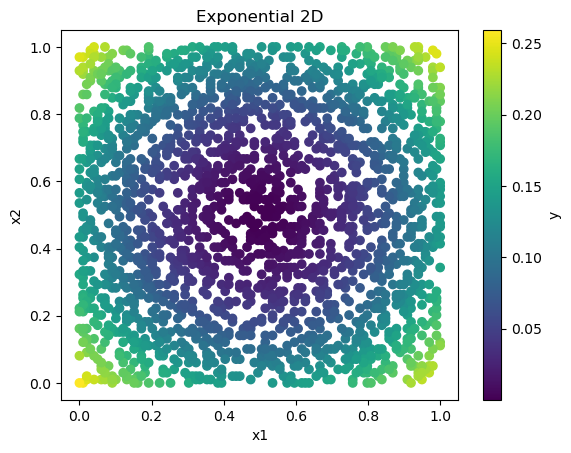

In [69]:
# i =9
# Al_df = np_data[np_data['type'].isin(name1[i*150:(i+1)*150])]
# Al_dfx = Al_df[featureNames]
# Al_dfy = Al_df[targetNames]


# Rd_df = np_data[np_data['type'].isin(name2[i*150:(i+1)*150])]
# Rd_dfx = Rd_df[featureNames]
# Rd_dfy = Rd_df[targetNames]

plt.figure()
#plt.scatter(Al_dfx,Al_dfy)
#plt.scatter(Rd_dfx,Rd_dfy)
plt.scatter(np_data['x1'],np_data['x2'],c=np_data['y'])
#plt.scatter(Al_dfx['x1'],Al_dfx['x2'],c = 'blue') # ,c=Al_dfy['y']
#plt.scatter(Rd_dfx['x1'],Rd_dfx['x2'],c= 'red') #Rd_dfy['y']

plt.colorbar(label = 'y')
plt.title("Exponential 2D")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()


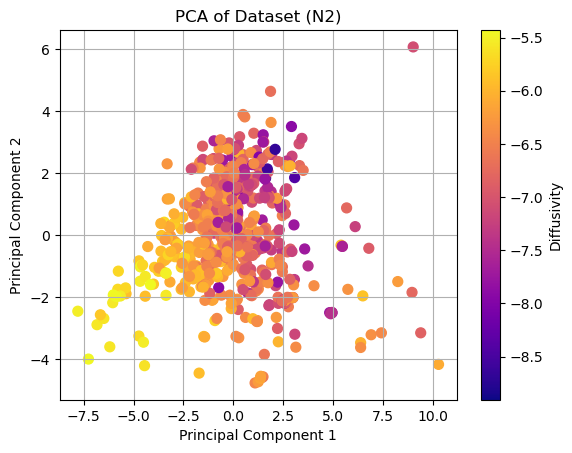

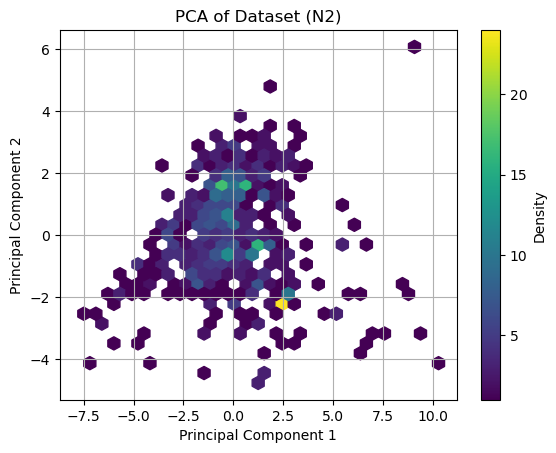

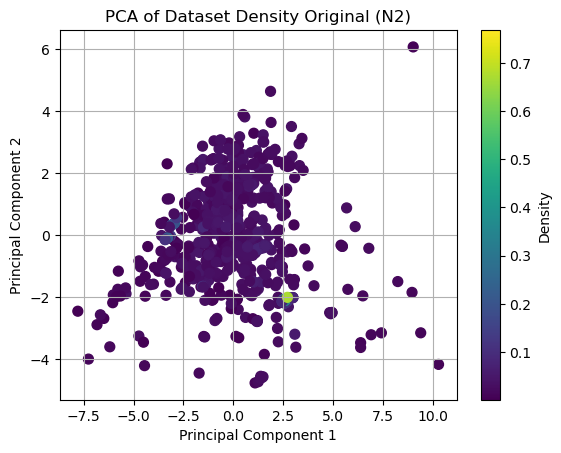

In [50]:
x = np_data[featureNames].to_numpy()
y = np_data[targetNames].to_numpy()

scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_normalized)

fig = plt.figure()
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='plasma', s=50)
plt.colorbar(scatter, label='Diffusivity')
plt.title('PCA of Dataset (N2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.grid(True)
plt.show()


fig = plt.figure()
plt.hexbin(X_pca[:, 0], X_pca[:, 1], gridsize=30, cmap='viridis', mincnt=1)
plt.colorbar(label='Density')
plt.title('PCA of Dataset (N2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.grid(True)
plt.show()


nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(x)
distances, indices = nbrs.kneighbors(x)
density = 1 / distances.mean(axis=1)


fig = plt.figure()
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=density, cmap='viridis', s=50)
plt.colorbar(scatter, label='Density')
plt.title('PCA of Dataset Density Original (N2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.grid(True)
plt.show()



In [ ]:
#Silhouette Score: Measures how similar each data point is to its own cluster compared to other clusters. Higher values (close to 1) indicate distinct clusters (more heterogeneity), while values close to 0 indicate overlap between clusters (less heterogeneity).
#Davies-Bouldin Index: Measures the average similarity ratio of each cluster with the one that is most similar to it. Lower values indicate better-defined clusters (higher heterogeneity).

Variance is [0.02548544]


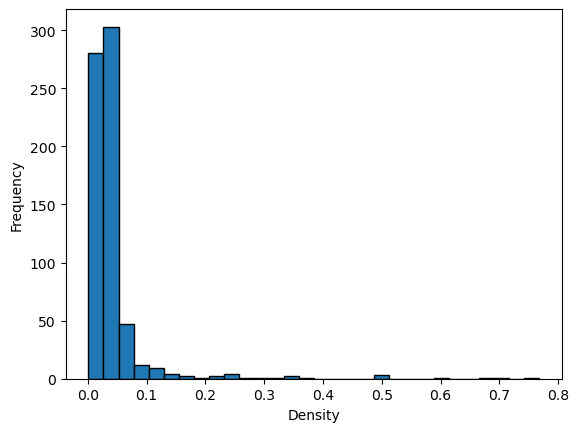

Silhouette score is: 0.4656305773920781


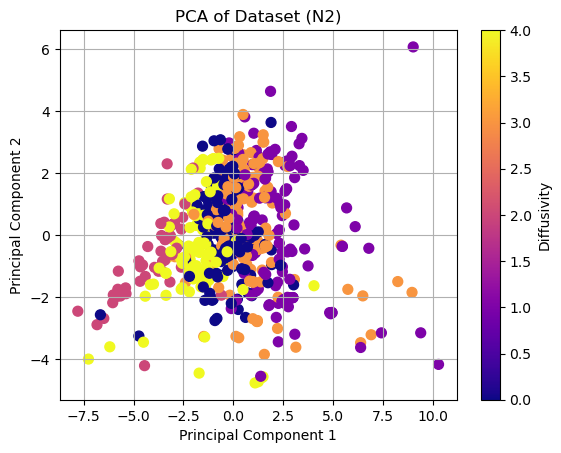

0.6844266355319993


In [49]:
### Space Analusis
x = np_data[featureNames].to_numpy()
y = np_data[targetNames].to_numpy()


scaler = MinMaxScaler()
y_norm = scaler.fit_transform(y.reshape(-1, 1))

variance = np.var(y_norm, axis=0)
#std_dev = np.std(x, axis=0)

print("Variance is",variance)
#print("Std is",std_dev)

nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(x)
distances, indices = nbrs.kneighbors(x)
density = 1 / distances.mean(axis=1)

fig = plt.figure()
plt.hist(density,bins=30,ec='black')
plt.xlabel('Density')
plt.ylabel('Frequency')
plt.show()

##### Kmeans Clustering
kmeans = KMeans(n_clusters=5).fit(x)
labels = kmeans.labels_
silhouette_avg = silhouette_score(x, labels)
print("Silhouette score is:",silhouette_avg)


scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_normalized)

fig = plt.figure()
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='plasma', s=50)
plt.colorbar(scatter, label='Diffusivity')
plt.title('PCA of Dataset (N2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.grid(True)
plt.show()

db_index = davies_bouldin_score(x, labels)
print(db_index)


In [24]:
# Function to calculate the fractal dimension using box-counting
def fractal_dimension(X, scale_min=1, scale_max=20):
    def box_count(data, box_size):
        min_bounds = np.min(data, axis=0)
        max_bounds = np.max(data, axis=0)
        grid_counts = np.ceil((max_bounds - min_bounds) / box_size).astype(int)
        
        # Create a grid of box_size x box_size and count occupied boxes
        occupied_boxes = np.zeros(grid_counts, dtype=bool)
        
        for point in data:
            grid_index = np.floor((point - min_bounds) / box_size).astype(int)
            occupied_boxes[tuple(grid_index)] = True

        return np.sum(occupied_boxes)

    # Get box sizes over a range of scales
    scales = np.arange(scale_min, scale_max)
    box_counts = np.zeros(len(scales))

    # Compute the number of occupied boxes for each scale
    for i, scale in enumerate(scales):
        box_counts[i] = box_count(X, scale)
    
    # Fit a line to the log-log plot of scale vs box count to estimate fractal dimension
    coeffs = np.polyfit(np.log(scales), np.log(box_counts), 1)
    return -coeffs[0]

##########################

x = np_data[featureNames].to_numpy()
y = np_data[targetNames].to_numpy()

scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_normalized)

fractal_dim = fractal_dimension(X_pca)

print(fractal_dim)



1.4020306074525317


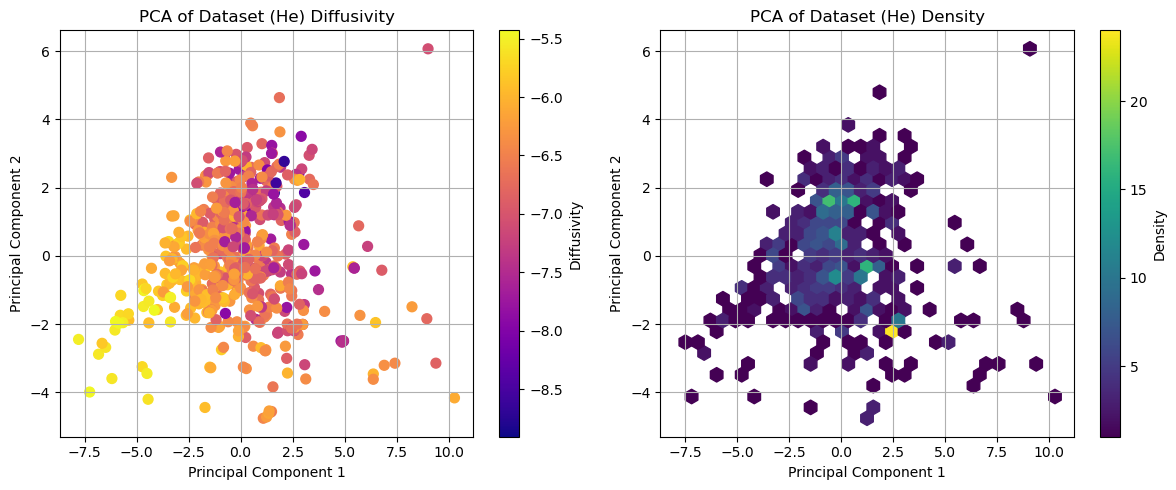

In [74]:
# Assuming np_data, featureNames, and targetNames are already defined
x = np_data[featureNames].to_numpy()
y = np_data[targetNames].to_numpy()

# Normalize the data
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_normalized)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Scatter plot
scatter = ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='plasma', s=50)
ax[0].set_title('PCA of Dataset (He) Diffusivity')
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')
ax[0].grid(True)
cbar1 = fig.colorbar(scatter, ax=ax[0])
cbar1.set_label('Diffusivity')

# Second subplot: Hexbin plot
hb = ax[1].hexbin(X_pca[:, 0], X_pca[:, 1], gridsize=30, cmap='viridis', mincnt=1)
ax[1].set_title('PCA of Dataset (He) Density')
ax[1].set_xlabel('Principal Component 1')
ax[1].set_ylabel('Principal Component 2')
ax[1].grid(True)
cbar2 = fig.colorbar(hb, ax=ax[1])
cbar2.set_label('Density')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [28]:
def create_results(res_path):
    
    df = pd.read_csv(res_path + '_0.csv')
    df = df[['averageError']]
    res = df
    for i in range(1,10):
        df = pd.read_csv(res_path + f'_{i}.csv')
        df = df[['averageError']]
        res += df

    return res / 10    


def stat_test(df1,df2):
    
    arr1 = df1.to_numpy()
    arr2 = df2.to_numpy()

    t_stat, p_value = stats.ttest_rel(arr1, arr2)
    return t_stat,p_value

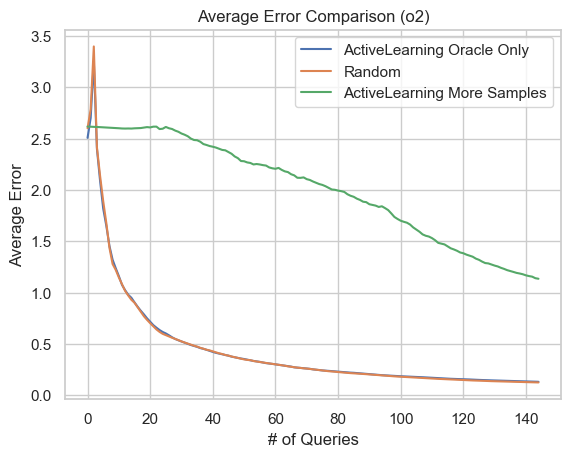

In [36]:
# Forrester
df1 = create_results('./ALresults/Synthetic/density/Forrester/Forrester_150_density')
df2 = create_results('./ALresults/Synthetic/igs/Forrester/Forrester_150_igs')
df3 = create_results('./ALresults/Synthetic/qbc/Forrester/Forrester_150_qbc')

df1 = df1[['averageError']]
df2 = df2[['averageError']]
df3 = df3[['averageError']]
plt.figure()
plt.plot(df1, label='ActiveLearning Oracle Only ')
plt.plot(df2, label='Random')
plt.plot(df3, label='ActiveLearning More Samples')
#plt.plot(df4, label='ActiveLearning with mae estimation')
#plt.axhline(y=8.13, color='red', linestyle='--', label='min Rand')
plt.xlabel('# of Queries')
plt.ylabel('Average Error')
plt.title('Average Error Comparison (Forrester)')
#plt.ylim(5,20)
#plt.xlim(0,150)
plt.legend()
plt.show()

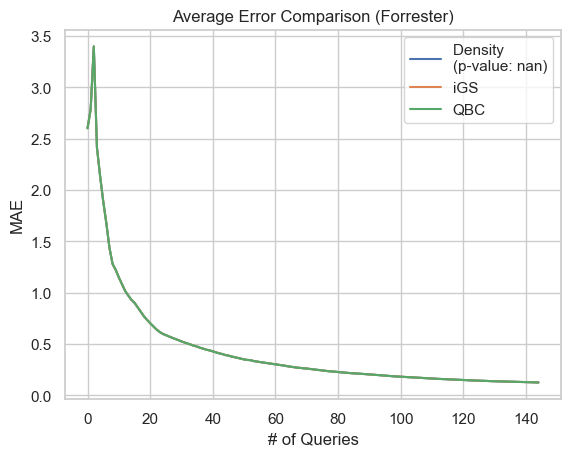

In [39]:
# df1 = pd.read_csv('./ALresults/Real/CH4/AL_ch4_150_oracle_only_density_0.csv')
# df2 = pd.read_csv('./ALresults/Real/CH4/Rd_ch4_150_full_0.csv')
# df3 = pd.read_csv('./ALresults/Real/He/AL_he_150_oracle_only_iGS.csv')
# df4 = pd.read_csv('./ALresults/Real/He/AL_he_150_oracle_only_density_active.csv')


# df1 = df1[['averageError']]
# df2 = df2[['averageError']]
# df3 = df3[['averageError']]
# df4 = df4[['averageError']]

# df1_1 = create_results('./ALresults/Real/N2/Al_n2_150_oracle_only_density2')
# df2_1 = create_results('./ALresults/Real/N2/Rd_n2_150_full')
# df3_1 = create_results('./ALresults/Real/N2/Al_n2_150_oracle_only_iGS2')
# df4_1 = create_results('./ALresults/Real/N2/Al_n2_150_oracle_only_tree')
# df5_1 = create_results('./ALresults/Real/N2/Al_n2_150_oracle_only_density')

df1_1 = create_results('./ALresults/Synthetic/Density/Forrester/Forrester_150_density')
df2_1 = create_results('./ALresults/Synthetic/igs/Forrester/Forrester_150_igs')
df3_1 = create_results('./ALresults/Synthetic/qbc/Forrester/Forrester_150_qbc')

t_v, p_v = stat_test(df1_1,df2_1)
p_v = p_v.item()

plt.figure()
plt.plot(df1_1, label='Density')
plt.plot(df2_1, label='iGS')
plt.plot(df3_1, label='QBC')
#plt.plot(df4_1, label='ActiveLearning RT')
# plt.plot(df5_1, label='ActiveLearning density')

plt.xlabel('# of Queries')
plt.ylabel('MAE')
plt.title('Average Error Comparison (Forrester)')

handles, labels = plt.gca().get_legend_handles_labels()

#labels.append(f'p-value: {p_v:.3e}')
labels[0] += f' \n(p-value: {p_v:.3e})'
plt.legend(handles, labels)
plt.show()

In [34]:
!pwd

/home/vassilis/Desktop/2023_Inverse_ZIF_paper/Active_Learning/working_notebook


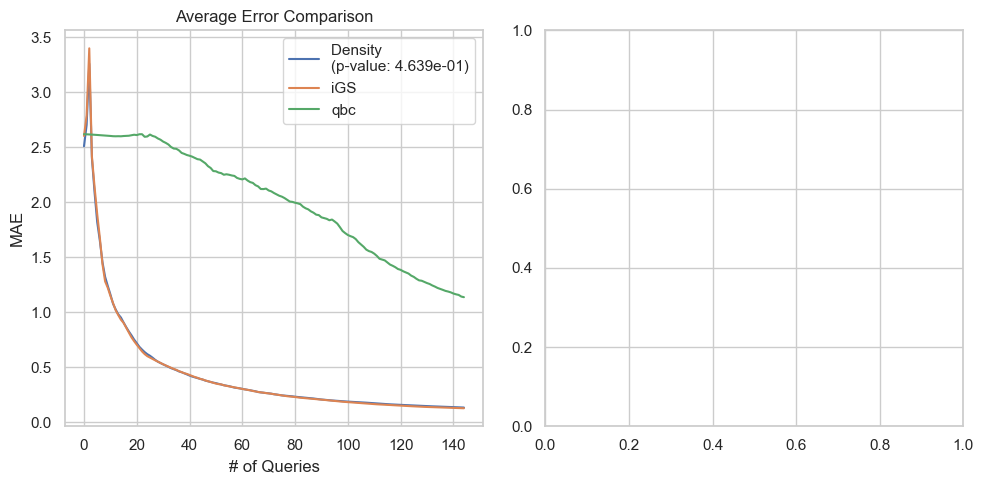

In [35]:
df1_1 = create_results('./ALresults/Synthetic/density/Forrester/Forrester_150_density')
df2_1 = create_results('./ALresults/Synthetic/igs/Forrester/Forrester_150_igs')
df3_1 = create_results('./ALresults/Synthetic/qbc/Forrester/Forrester_150_qbc')

# df1_2 = create_results('./ALresults/Synthetic/Exponential/Exponential_imb/Al_exp_150_oracle_only_density')
# df2_2 = create_results('./ALresults/Synthetic/Exponential/Exponential_imb/Rd_exp_150_full')
# df3_2 = create_results('./ALresults/Synthetic/Exponential/Exponential_imb/Al_exp_150_oracle_only_iGS')

# Perform statistical tests
t_v1, p_v1 = stat_test(df1_1, df2_1)
# t_v2, p_v2 = stat_test(df1_2, df2_2)

# Convert p-values to scalar if needed
p_v1 = p_v1.item()
# p_v2 = p_v2.item()

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
ax[0].plot(df1_1, label='Density')
ax[0].plot(df2_1, label='iGS')
ax[0].plot(df3_1, label='qbc')
ax[0].set_xlabel('# of Queries')
ax[0].set_ylabel('MAE')
ax[0].set_title('Average Error Comparison')
handles, labels = ax[0].get_legend_handles_labels()
labels[0] += f' \n(p-value: {p_v1:.3e})'
ax[0].legend(handles, labels)

# Second subplot
# ax[1].plot(df1_2, label='ActiveLearning density')
# ax[1].plot(df2_2, label='Random')
# ax[1].plot(df3_2, label='ActiveLearning iGS')
# ax[1].set_xlabel('# of Queries')
# ax[1].set_ylabel('MAE')
# ax[1].set_title('Average Error Comparison (Heterogeneous Exponential)')
# handles, labels = ax[1].get_legend_handles_labels()
# labels[0] += f' \n(p-value: {p_v2:.3e})'
# ax[1].legend(handles, labels)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

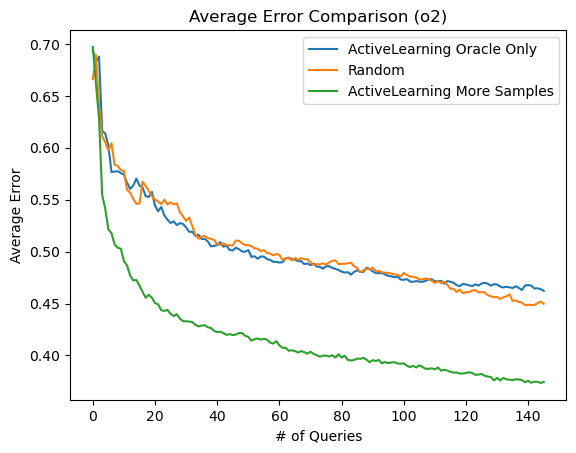

In [72]:
# Oxygen Only
df1 = pd.read_csv('./ALresults/AL_o2n2_150_oracle_only_cat.csv')
df2 = pd.read_csv('./ALresults/Rd_o2n2_150_full.csv')
df3 = pd.read_csv('./ALresults/AL_o2n2_150_more_samples.csv')

df1 = df1[['averageError']]
df2 = df2[['averageError']]
df3 = df3[['averageError']]
plt.figure()
plt.plot(df1, label='ActiveLearning Oracle Only ')
plt.plot(df2, label='Random')
plt.plot(df3, label='ActiveLearning More Samples')
#plt.plot(df4, label='ActiveLearning with mae estimation')
#plt.axhline(y=8.13, color='red', linestyle='--', label='min Rand')
plt.xlabel('# of Queries')
plt.ylabel('Average Error')
plt.title('Average Error Comparison (o2)')
#plt.ylim(5,20)
#plt.xlim(0,150)
plt.legend()
plt.show()

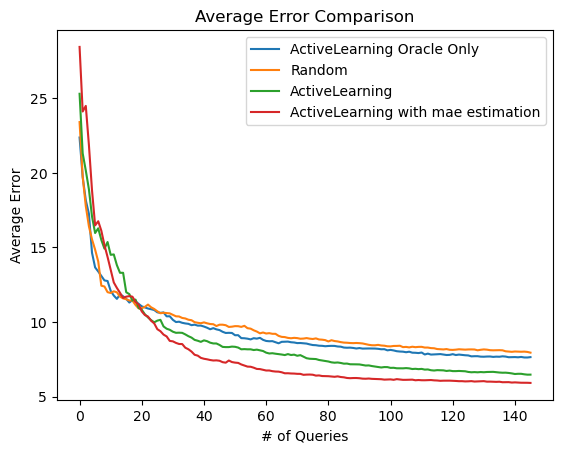

In [105]:
df1 = pd.read_csv('./ALresults/AL_meth_150_oracle_only.csv')
df2 = pd.read_csv('./ALresults/Rd_meth_100_full.csv')
df3 = pd.read_csv('./ALresults/AL_meth_150_more_samples.csv')
df4 = pd.read_csv('./ALresults/AL_meth_150_more_samples_mae_est.csv')



df1 = df1[['averageError']]
df2 = df2[['averageError']]
df3 = df3[['averageError']]
df4 = df4[['averageError']]


plt.figure()
plt.plot(df1, label='ActiveLearning Oracle Only ')
plt.plot(df2, label='Random')
plt.plot(df3, label='ActiveLearning')
plt.plot(df4, label='ActiveLearning with mae estimation')
#plt.axhline(y=8.13, color='red', linestyle='--', label='min Rand')
plt.xlabel('# of Queries')
plt.ylabel('Average Error')
plt.title('Average Error Comparison')
#plt.ylim(5,20)
#plt.xlim(0,150)
plt.legend()
plt.show()

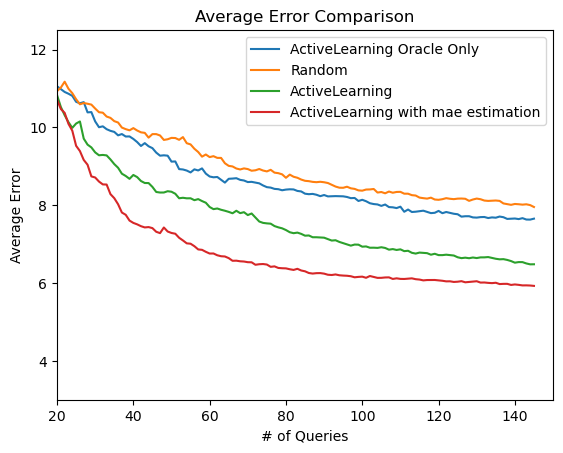

In [106]:
df1 = pd.read_csv('./ALresults/AL_meth_150_oracle_only.csv')
df2 = pd.read_csv('./ALresults/Rd_meth_100_full.csv')
df3 = pd.read_csv('./ALresults/AL_meth_150_more_samples.csv')
df4 = pd.read_csv('./ALresults/AL_meth_150_more_samples_mae_est.csv')


df1 = df1[['averageError']]
df2 = df2[['averageError']]
df3 = df3[['averageError']]
df4 = df4[['averageError']]

plt.figure()
plt.plot(df1, label='ActiveLearning Oracle Only ')
plt.plot(df2, label='Random')
plt.plot(df3, label='ActiveLearning')
plt.plot(df4, label='ActiveLearning with mae estimation')
plt.xlabel('# of Queries')
plt.ylabel('Average Error')
plt.title('Average Error Comparison')
plt.ylim(3,12.5)
plt.xlim(20,150)
plt.legend()
plt.show()

   sizeOfTrainingSet  averageError  stdErrorOfMeanError  \
0                  5      3.736963             0.437900   
1                  6      3.553431             0.400896   
2                  7      3.583923             0.556732   
3                  8      3.450646             0.482377   
4                  9      3.387176             0.438661   

   stdDeviationOfMeanError  
0                 0.979173  
1                 0.981989  
2                 1.472973  
3                 1.364368  
4                 1.315983  


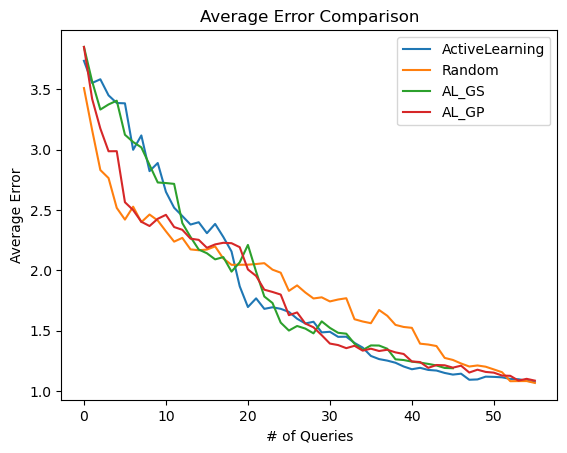

In [79]:
df1 = pd.read_csv('./ALresults/All_zifs/AL_500.csv')
df2 = pd.read_csv('./ALresults/All_zifs/Rd_500.csv')
df3 = pd.read_csv('./ALresults/AL_meth_100_bs.csv')
df4 = pd.read_csv('./ALresults/All_zifs/AL_500_gp.csv')


print(df1.head())
df1 = df1[['averageError']]
df2 = df2[['averageError']]
df3 = df3[['averageError']]
df4 = df4[['averageError']]

plt.figure()
plt.plot(df1, label='ActiveLearning')
plt.plot(df2, label='Random')
plt.plot(df3, label='AL_GS')
plt.plot(df4, label='AL_GP')
plt.xlabel('# of Queries')
plt.ylabel('Average Error')
plt.title('Average Error Comparison')
#plt.ylim(0,9)
#plt.xlim(0,100)
plt.legend()
plt.show()